# Zeitreihenanalyse mit Bitcoin

## Inhaltsverzeichnis
### 1 [Einleitung](#einleitung)
### 2 [Hilfsfunktionen](#hilfsfunktionen)
### 3 [Datenverarbeitung](#datenverarbeitung)
#### 3.1 [Erster Blick](#erster-blick)
#### 3.2 [Betrachtung aller Daten](#betrachung-aller-daten)
#### 3.3 [Verarbeitung der Daten](#verarbeitung-aller-daten)
#### 3.4 [die letzten 1000 Werte](#letzten-1000)
#### 3.5 [Preisänderungen](#preisänderung)
#### 3.6 [Zeitliche Lücken](#zeitliche-lücken)
### 4 [Arima Analyse](#arima-analyse)
#### 4.1 [Arima-Modell](#arima-modell)
##### 4.1.1 [Differenzierung](#differenzierung)
##### 4.1.2 [Tests](#tests)
#### 4.2 [Arima-Vorgehen](#arima-vorgehen)
#### 4.3 [Eine Minute](#eine-minute)
#### 4.4 [Zwei Minuten](#zwei-minuten)
#### 4.5 [Drei Minuten](#drei-minuten)
#### 4.6 [Vier Minuten](#vier-minuten)
#### 4.7 [Fünf Minuten](#fünf-minuten)
### 5 [Abschluss](#abschluss)

## Einleitung <a id="einleitung"></a>
Ziel dieses Notebooks ist eine Zeitreihenanalyse auf Bitcoinkurse anzuwenden. Dabei werden die Daten am Anfang kurz analysiert und weiterverarbeitet. Danach werden geeignete Zeitreihendaten von dem gesamten Datensatz selektiert. Diese werden dann jeweils in einen Trainingsdatensatz und einen Testdatensatz unterteilt und jeweils auf den Trainingsdaten eine Arima Analyse durchgeführt. An deren Ende soll eine Vorhersage mit den Trainingsdaten gemacht werden, die mit den Testdaten verglichen wird. Am Ende werden die Ergebnisse kurz zusammengefasst.

## Hilfsfunktionen <div id='hilfsfunktionen'/>

In [1]:
import pandas
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from psycopg2 import OperationalError
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as scs
# import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as smt
import statsmodels.graphics.tsaplots
from setuptools import sic
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

from arch.unitroot import PhillipsPerron

from scipy import stats

import numpy as np
from datetime import datetime, timedelta
import pickle

In [2]:
def connect_database():
    connection = psycopg2.connect(dbname="postgres", user="postgres", password="test", host="149.201.206.233")
    return connection




def get_all_data_from_conn(connection, amount = 200, allData = False):
    cur = connection.cursor()
    if allData == True:
        execute_str = "select * from btc_tick_data"
    else:
        execute_str = "select * from btc_tick_data limit " + str(amount)

    cur.execute(execute_str)
    tuples = cur.fetchall()
    cur.close()
    df = pd.DataFrame(tuples)

    return df




In [3]:
def get_all_data_with_names(connection, amount = 200, allData = False):
    cur = connection.cursor()
    if allData == True:
        execute_str = "select * from btc_tick_data"
    else:
        execute_str = "select * from btc_tick_data limit " + str(amount)

    cur.execute(execute_str)
    tuples = cur.fetchall()
    cur.close()
    df = pd.DataFrame(tuples, columns = ["best_ask_price"])

    return df

def get_local_data(file_dir = "data", amount = 200, allData = False):
    file = open(file_dir,"rb")
    data = pickle.load(file)
    if allData == False:
        return data[0:amount]
    return data

def price_differences(dataframe):
    price = dataframe["a_price"]
    size = len(price)
    price_diff = np.zeros(size)
    price_diff_perc = np.zeros(size)
    for i in range(1,size-1):
        price_diff[i] = price[i] - price[i-1]
        price_diff_perc[i] = price_diff[i]/price[i-1]
    return price_diff, price_diff_perc

def convert_to_dic(data)->pd.Series:
    price_diffs, price_diff_perc = price_differences(data)
    temp_data_frame = pd.DataFrame({"date": data[0], "a_price":data[1], "price_diffs": price_diffs,"price_diff_perc": price_diff_perc, "a_whole_lot_volume:Ask":data[2], "a_lot_volume: Ask":data[3], "b_price":data[4], "b_whole_lot_volume: Bid":data[5],
                                 "b_lot_volume: Bid":data[6], "c_price":data[7], "c_lot_volume: Close":data[8], "v_today: Volume":data[9], "v_24: Volume":data[10], "p_today:":data[11], "p_24":data[12],
                                 "t_today":data[13], "t_24":data[14], "l_today":data[15], "l_24":data[16], "h_today":data[17], "h_24":data[18], "o_today":data[19], "o_24":data[20]})
    re_indexed = temp_data_frame.set_index("date")
    return (re_indexed)

In [4]:


def get_all_data(local=True, file_dir = "data", amount = 200, allData = False, dict = True):
    if local == True:
        return get_local_data(file_dir,amount,allData)
    else:
        try:
            conn = connect_database()
            data = get_all_data_from_conn(conn,amount,allData)
            if dict == True:
                return convert_to_dic(data)
            return data
        except OperationalError:
            return get_local_data(file_dir,amount,allData)

In [5]:
def ts_diff(dataset, periods=1):
    diff = list()
    ret = dataset
    for i in range(periods, len(dataset)):
        value = dataset[i] - dataset[i - periods]
        ret[i] = value
    return ret

def inverse_ts_diff(history, yhat, periods=1):
    return yhat + history[-periods]


def get_tests_for_stationarity(resids):
    print("Dickey-Fuller Test")
    dickey_fuller = sm.tsa.stattools.adfuller(resids)
    print(f'Dickey-Fuller Statistic: {dickey_fuller[0]}')
    print(f'p-value: {dickey_fuller[1]}')

    print(f'Result: The series is {" " if dickey_fuller[1] < 0.05 else "not stationary"}stationary')
    print("KPSS Test")
    statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(resids)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

    print("PhillipsPerron Test")
    pp = PhillipsPerron(resids)
    print(pp.summary().as_text())


def get_tests_for_residuals(resids):
    print("Ljung-Box-Test")
    ljung_box_test = sm.stats.acorr_ljungbox(resids, lags=[len(resids) -1 ], return_df=True )
    print(f'Ljung-Box-Test Statistic: {ljung_box_test["lb_stat"].values[0]}')
    print(f'Ljung-Box-Test P-Value: {ljung_box_test["lb_pvalue"].values[0]}')
    print(f'Result: The residuals are {" " if ljung_box_test["lb_pvalue"].values[0] > 0.05 else "not"} identical independent distributed')

    print("Shapiro-Wilk-Test")
    shapiro_wilk_test = stats.shapiro(resids)
    print(f'Shapiro-Wilk-Test Statistic: {shapiro_wilk_test.statistic}')
    print(f'Shapiro-Wilk-Test P-Value: {shapiro_wilk_test.pvalue}')
    print(f'Result: The residuals are {" " if shapiro_wilk_test.pvalue > 0.05 else "not"} normal independent distributed ')
    

In [6]:
def plot_general_acf_pacf_and_dickey(timeseries, lags=60):
    fig = plt.figure(figsize=(10,6))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    timeseries.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(timeseries)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.tsaplots.plot_acf(timeseries, lags=lags, ax=acf_ax)
    smt.graphics.tsaplots.plot_pacf(timeseries, lags=lags, ax=pacf_ax, method="ywm")
    plt.tight_layout()
    plt.show()

In [7]:

def transform_ts_without_microseconds(ts):
    temp = ts.index[0].replace(microsecond = 0)
    temp
    time_index = ts.index
    size = len(time_index)

    ret_index = []
    ret_values = []
    i = 0
    while i < size:
        datetime = time_index[i].replace(microsecond = 0)
        same_indexes = [datetime]
        temp_ret_values = [ts[i]]
        j = i
        # collect all values in the same millisecond intervall
        while((j < size-1) and (time_index[j+1].replace(microsecond = 0) == time_index[j].replace(microsecond = 0)) ):
            same_indexes.append(time_index[j+1].replace(microsecond = 0))
            temp_ret_values.append(ts[j+1])
            j = j + 1
            i = i + 1

        i = i + 1
        if i == size:
            break
        avg = np.mean(temp_ret_values)
        ret_index.append(time_index[i].replace(microsecond = 0))
        ret_values.append(avg)

    ret = pd.Series(ret_values, index=ret_index)
    print(ret)
    print(len(ret))
    return ret

In [8]:
def constant_index_ts(data, constant_second_step = 1, constant_minute_step = 0 )-> pd.Series:
    ts = data
    temp = ts.index[0].replace(microsecond = 0)
    temp
    time_index = ts.index
    size = len(time_index)

    ret_values = []
    start = time_index[0].replace(microsecond = 0) + timedelta(0,seconds=constant_second_step, minutes=constant_minute_step)
    end = time_index[size-1].replace(minute = 0).replace(microsecond = 0)
    index_generated = [start]
    date_step = start
    while(date_step <= end):
        date_step = date_step + timedelta(0,constant_second_step, minutes=constant_minute_step)
        print(date_step)
        index_generated.append(date_step)

    n = len(index_generated)
    j_start = 0
    for i in range(n):
        temp_ret_values = []
        j = j_start
        while(time_index[j] <= index_generated[i] ):
            temp_ret_values.append(data[j])
            j = j + 1
        if len(temp_ret_values) == 0 and i > 0:
            temp_ret_values.append(ret_values[i-1])
        j_start = j
        avg = np.mean(temp_ret_values)
        ret_values.append(avg)

    ret = pd.Series(ret_values, index=index_generated)
    return ret

In [9]:
def get_outliers(data, column_name, mu, sigma, n_sigmas=3):
    '''
    data: the DataFrame
    mu: mean
    sigmas: std
    n_sigmas: number of std as boundary
    '''
    if type(data) == pandas.DataFrame:
        x = data[column_name]
    elif type(data) == pandas.Series:
        x = data
    else:
        print("keine Series oder DataFrame")

    mu = mu
    sigma = sigma
    print(x)
    ret = []
    for elment in x:
        if (elment > mu+n_sigmas*sigma) or (elment<mu-n_sigmas*sigma):
            ret.append(1)
        else:
            ret.append(0)
    return ret

In [10]:

def plot_data_moving_avg_std_data_frame(data_frame,column_name, std_mult = 1):
    size = len(data_frame)
    moving_avg = np.empty([1,size-1])
    for i in range(1,size):
        moving_avg[0][i-1] = data_frame[column_name].rolling(window=i).mean()[i]

    data_frame_mean_std = data_frame[column_name].agg(['mean','std'])
    fig, ax = plt.subplots(figsize=(20,8))
    x = data_frame.index
    y = data_frame[column_name]

    print(data_frame_mean_std.loc['mean'])
    print(data_frame_mean_std.loc['std'])
    plt.axhline(y=data_frame_mean_std.loc['mean'], c='r', label='mean')
    plt.axhline(y=std_mult*(data_frame_mean_std.loc['mean']-data_frame_mean_std.loc['std']), c='c',linestyle='-.', label='std')
    plt.axhline(y=std_mult*(data_frame_mean_std.loc['mean']+data_frame_mean_std.loc['std']), c='c',linestyle='-.', label='std')
    plt.plot(x[0:size-1], moving_avg[0],c="orange", label="moving_avg")
    plt.legend(loc='lower right')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y/%H:%M'))
    plt.plot(x,y)
    plt.show()

def plot_data_moving_avg_std_ts(time_series, outliers = None,  std_mult = 1):
    size = len(time_series)
    moving_avg = np.empty([size])
    for i in range(size):
        moving_avg[i] = np.mean(time_series[0:i-1])

    time_series_std = time_series.std()
    time_series_mean = time_series.mean()
    fig, ax = plt.subplots(figsize=(20,8))
    print(time_series_mean)
    print(time_series_std)
    if outliers is not None:
        scatter_color = np.where(np.abs(outliers*time_series) > 0 , "red", "white")
        ax.scatter(time_series.index, outliers*time_series , color = scatter_color, label = "Anomaly")
    # ax.scatter(time_series.index, outliers*time_series)
    plt.plot(time_series.index, moving_avg,c="r", label="moving_avg")
    plt.axhline(y=time_series_mean, c='orange',linestyle=':' ,label='mean')
    plt.axhline(y=std_mult*(time_series_mean-time_series_std), c='c',linestyle='-.', label='std')
    plt.axhline(y=std_mult*(time_series_mean+time_series_std), c='c',linestyle='-.', label='std')
    plt.legend(loc='lower right')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y/%H:%M'))
    plt.plot(time_series)
    plt.show()

In [11]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [12]:
def prediction_with_confidence(train_ts_arima, train_ts, data_ts, start, end, dynamic=False, start_plot=800):
    size = len(data_ts)
    moving_avg = np.empty([size])
    for i in range(start_plot,size):
        moving_avg[i] = np.mean(data_ts[0:i-1])

    fig = plt.figure(figsize=(20,10))
    data_train_ts_arima_pred = train_ts_arima.get_prediction(start=start, end=end,dynamic=dynamic)
    index_of_fc = data_ts.index[len(data_ts)-100:len(data_ts)]
    confint = data_train_ts_arima_pred.conf_int()
    lower_series = pd.Series(confint.iloc[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint.iloc[:, 1], index=index_of_fc)
    plt.plot(train_ts[start_plot:len(train_ts)], color="blue", label="trainings zeitreihe")
    plt.plot(data_train_ts_arima_pred.predicted_mean[start_plot:len(data_train_ts_arima_pred.predicted_mean)], color="orange", label="prediction")
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15, label="konfidenzintervall")
    plt.plot(data_ts[len(train_ts):len(data_ts)], color="red", label="test zeitreihe")
    plt.plot(data_ts.index[start_plot:len(data_ts)], moving_avg[start_plot:len(data_ts)],c="green", label="moving_avg")
    plt.legend(loc="upper left")
    plt.show()

## Datenverarbeitung <div id='datenverarbeitung'/>

Die Daten wurden von einem Server geladen und lokal abgespeichert. Die Daten beinhalten Zeitstempel und dazugehörige Informationen zu dem Bitcoin. Wir werden in der folgenden Analyse auf den Ask-Preis konzentrieren.

### Ein erster Blick <div id='erster-blick'/>

Hier werden wir uns kurz die Daten anschauen, um einen ersten Eindruck von deren Struktur zu bekommmen.

In [13]:
all_data = get_all_data(allData = True)

Die Daten werden durch diese Funktion vom Netz oder von der lokalen Festplatte geladen.

In [14]:
data_sample_100 = get_all_data(amount=100)
data_sample_100.head()

,a_price,a_whole_lot_volume:Ask,a_lot_volume: Ask,b_price,b_whole_lot_volume: Bid,b_lot_volume: Bid,c_price,c_lot_volume: Close,v_today: Volume,v_24: Volume,p_today:,p_24,t_today,t_24,l_today,l_24,h_today,h_24,o_today,o_24
date,,,,,,,,,,,,,,,,,,,,
2022-02-24 14:27:03.226577+01:00,31623.8,0.0,0.011527,31609.0,0.0,0.250000,31623.9,0.000623,2881.426612,3605.046515,31509.37146,31935.39880,33716.0,46454.0,30570.0,30570.0,33095.5,33095.5,32943.7,34448.9
2022-02-24 14:27:03.417405+01:00,31620.8,0.0,0.143930,31609.2,0.0,0.039226,31620.8,0.006070,2881.432682,3605.052585,31509.37170,31935.39827,33717.0,46455.0,30570.0,30570.0,33095.5,33095.5,32943.7,34448.9
2022-02-24 14:27:11.516382+01:00,31629.4,4.0,4.244219,31617.3,0.0,0.250000,31629.4,0.001558,2881.434240,3603.407713,31509.37176,31934.24968,33718.0,46452.0,30570.0,30570.0,33095.5,33095.5,32943.7,34452.7
2022-02-24 14:27:12.327173+01:00,31629.4,4.0,4.241103,31620.3,0.0,0.020000,31629.4,0.003116,2881.437355,3603.410829,31509.37189,31934.24942,33719.0,46453.0,30570.0,30570.0,33095.5,33095.5,32943.7,34452.7
2022-02-24 14:27:14.762562+01:00,31619.5,4.0,4.246701,31607.7,0.0,0.336521,31607.7,0.032108,2881.469463,3603.414202,31509.37299,31934.22642,33720.0,46453.0,30570.0,30570.0,33095.5,33095.5,32943.7,34448.9


Wir schauen uns hier kurz an, ob die Verarbeitung der Daten die gewünschte Form bringen und uns dafür die ersten 100 Daten selektiert. Die Daten wurden in einen Dictionary mit den entsprechenden Namen für die Spalten umgewandelt.

In [15]:
data_sample_100['a_price'][1]

31620.8

In [16]:
data_sample_100.head()

,a_price,a_whole_lot_volume:Ask,a_lot_volume: Ask,b_price,b_whole_lot_volume: Bid,b_lot_volume: Bid,c_price,c_lot_volume: Close,v_today: Volume,v_24: Volume,p_today:,p_24,t_today,t_24,l_today,l_24,h_today,h_24,o_today,o_24
date,,,,,,,,,,,,,,,,,,,,
2022-02-24 14:27:03.226577+01:00,31623.8,0.0,0.011527,31609.0,0.0,0.250000,31623.9,0.000623,2881.426612,3605.046515,31509.37146,31935.39880,33716.0,46454.0,30570.0,30570.0,33095.5,33095.5,32943.7,34448.9
2022-02-24 14:27:03.417405+01:00,31620.8,0.0,0.143930,31609.2,0.0,0.039226,31620.8,0.006070,2881.432682,3605.052585,31509.37170,31935.39827,33717.0,46455.0,30570.0,30570.0,33095.5,33095.5,32943.7,34448.9
2022-02-24 14:27:11.516382+01:00,31629.4,4.0,4.244219,31617.3,0.0,0.250000,31629.4,0.001558,2881.434240,3603.407713,31509.37176,31934.24968,33718.0,46452.0,30570.0,30570.0,33095.5,33095.5,32943.7,34452.7
2022-02-24 14:27:12.327173+01:00,31629.4,4.0,4.241103,31620.3,0.0,0.020000,31629.4,0.003116,2881.437355,3603.410829,31509.37189,31934.24942,33719.0,46453.0,30570.0,30570.0,33095.5,33095.5,32943.7,34452.7
2022-02-24 14:27:14.762562+01:00,31619.5,4.0,4.246701,31607.7,0.0,0.336521,31607.7,0.032108,2881.469463,3603.414202,31509.37299,31934.22642,33720.0,46453.0,30570.0,30570.0,33095.5,33095.5,32943.7,34448.9


Hier werden wir kurz den Durchschnitt und die Standardabweichung des Ask Preises berechnen.

In [17]:
d1_mean = data_sample_100['a_price'].agg(['mean','std'])

In [18]:
d1_mean

mean    31662.213000
std        35.879218
Name: a_price, dtype: float64

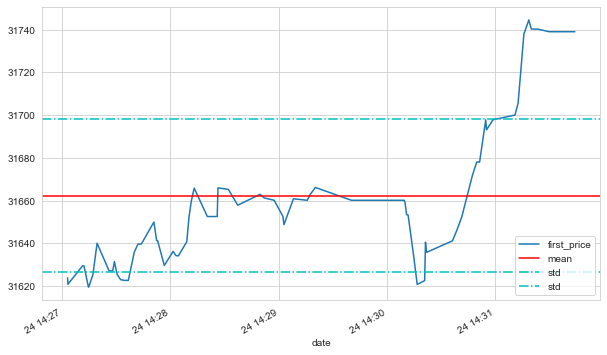

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
data_sample_100['a_price'].plot(label='first_price', legend=True, ax = ax)
plt.axhline(y=d1_mean.loc['mean'], c='r', label='mean')
plt.axhline(y=d1_mean.loc['mean']-d1_mean.loc['std'], c='c',linestyle='-.', label='std')
plt.axhline(y=d1_mean.loc['mean']+d1_mean.loc['std'], c='c',linestyle='-.', label='std')
plt.legend(loc='lower right')

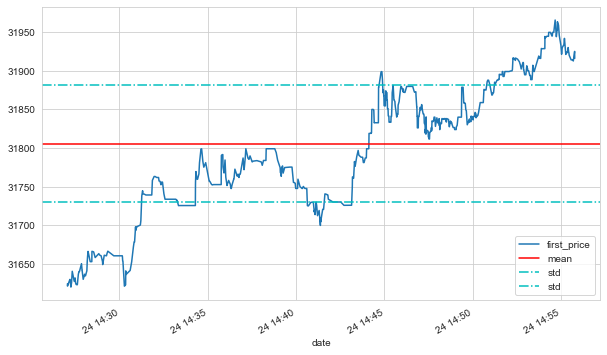

In [20]:
data_sample_1000  = get_all_data( amount=1000)
data_sample_1000_mean = data_sample_1000['a_price'].agg(['mean','std'])
fig, ax = plt.subplots(figsize=(10,6))
data_sample_1000['a_price'].plot(label='first_price', legend=True, ax = ax)
plt.axhline(y=data_sample_1000_mean.loc['mean'], c='r', label='mean')
plt.axhline(y=data_sample_1000_mean.loc['mean']-data_sample_1000_mean.loc['std'], c='c',linestyle='-.', label='std')
plt.axhline(y=data_sample_1000_mean.loc['mean']+data_sample_1000_mean.loc['std'], c='c',linestyle='-.', label='std')
plt.legend(loc='lower right')

Hier haben wir ein Diagramm erstellt das den Durchschnitt und die Standardabweichung der ersten 1000 Daten anzeigt. Da wir die gesamten gespeicherten Daten betrachten wollen, werden wir nun alle Daten in das Notebook laden.

### Betrachtung aller Daten
Nachdem wir uns die letzten 1000 Daten angeschaut haben, werden wir hier alle Daten laden, die vom Server lokal abgespeichert wurden. Dabei werden wir sehen das einige Daten gefiltert werden müssen. 

In [21]:
data_sample_all  = get_all_data(  allData=True)
data_sample_all_mean = data_sample_all['a_price'].agg(['mean','std'])


In [22]:
data_sample_all_mean = data_sample_all['a_price'].agg(['mean','std'])
data_sample_all.index

Index([2022-02-24 14:27:03.226577+01:00, 2022-02-24 14:27:03.417405+01:00,
       2022-02-24 14:27:11.516382+01:00, 2022-02-24 14:27:12.327173+01:00,
       2022-02-24 14:27:14.762562+01:00, 2022-02-24 14:27:14.960377+01:00,
       2022-02-24 14:27:17.241706+01:00, 2022-02-24 14:27:19.567692+01:00,
       2022-02-24 14:27:26.186699+01:00, 2022-02-24 14:27:28.207440+01:00,
       ...
       2022-04-04 08:12:37.055436+02:00, 2022-04-04 08:12:37.068298+02:00,
       2022-04-04 08:12:42.115366+02:00, 2022-04-04 08:12:42.127860+02:00,
       2022-04-04 08:12:44.035140+02:00, 2022-04-04 08:12:44.047492+02:00,
       2022-04-04 08:12:47.006623+02:00, 2022-04-04 08:12:47.019317+02:00,
       2022-04-04 08:12:47.595969+02:00, 2022-04-04 08:12:47.608875+02:00],
      dtype='object', name='date', length=881839)

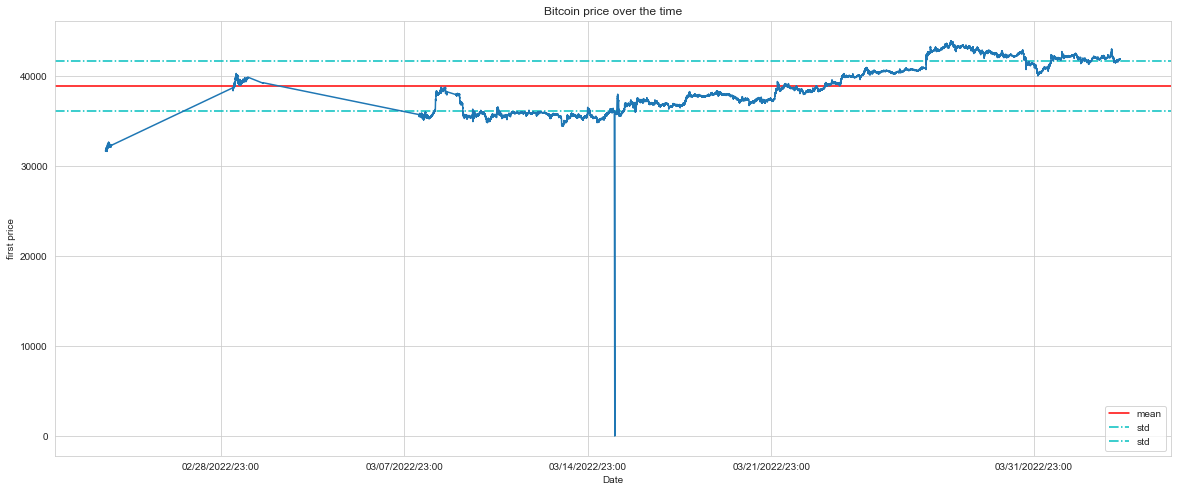

In [23]:
fig, ax = plt.subplots(figsize=(20,8))
x = data_sample_all.index
y = data_sample_all['a_price']
plt.axhline(y=data_sample_all_mean.loc['mean'], c='r', label='mean')
plt.axhline(y=data_sample_all_mean.loc['mean']-data_sample_all_mean.loc['std'], c='c',linestyle='-.', label='std')
plt.axhline(y=data_sample_all_mean.loc['mean']+data_sample_all_mean.loc['std'], c='c',linestyle='-.', label='std')
plt.legend(loc='lower right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y/%H:%M'))
ax.set(xlabel="Date",
      ylabel="first price",
      title="Bitcoin price over the time")
plt.plot(x,y)

Wir sehen hier das zu bestimmten Zeitpunkten der Ask-Preis auf 0 fällt. Dieser Wert hat für uns keinen Wert bezüglich einer weiteren analyse und wir werden ihn rausfiltern.

In [24]:
data_sample_all[['a_price']]

,a_price
date,
2022-02-24 14:27:03.226577+01:00,31623.8
2022-02-24 14:27:03.417405+01:00,31620.8
2022-02-24 14:27:11.516382+01:00,31629.4
2022-02-24 14:27:12.327173+01:00,31629.4
2022-02-24 14:27:14.762562+01:00,31619.5
...,...
2022-04-04 08:12:44.047492+02:00,41869.5
2022-04-04 08:12:47.006623+02:00,41869.5
2022-04-04 08:12:47.019317+02:00,41869.5


In [25]:
data_sample_all

,a_price,a_whole_lot_volume:Ask,a_lot_volume: Ask,b_price,b_whole_lot_volume: Bid,b_lot_volume: Bid,c_price,c_lot_volume: Close,v_today: Volume,v_24: Volume,p_today:,p_24,t_today,t_24,l_today,l_24,h_today,h_24,o_today,o_24
date,,,,,,,,,,,,,,,,,,,,
2022-02-24 14:27:03.226577+01:00,31623.8,0.0,0.011527,31609.0,0.0,0.250000,31623.9,0.000623,2881.426612,3605.046515,31509.37146,31935.39880,33716.0,46454.0,30570.0,30570.0,33095.5,33095.5,32943.7,34448.9
2022-02-24 14:27:03.417405+01:00,31620.8,0.0,0.143930,31609.2,0.0,0.039226,31620.8,0.006070,2881.432682,3605.052585,31509.37170,31935.39827,33717.0,46455.0,30570.0,30570.0,33095.5,33095.5,32943.7,34448.9
2022-02-24 14:27:11.516382+01:00,31629.4,4.0,4.244219,31617.3,0.0,0.250000,31629.4,0.001558,2881.434240,3603.407713,31509.37176,31934.24968,33718.0,46452.0,30570.0,30570.0,33095.5,33095.5,32943.7,34452.7
2022-02-24 14:27:12.327173+01:00,31629.4,4.0,4.241103,31620.3,0.0,0.020000,31629.4,0.003116,2881.437355,3603.410829,31509.37189,31934.24942,33719.0,46453.0,30570.0,30570.0,33095.5,33095.5,32943.7,34452.7
2022-02-24 14:27:14.762562+01:00,31619.5,4.0,4.246701,31607.7,0.0,0.336521,31607.7,0.032108,2881.469463,3603.414202,31509.37299,31934.22642,33720.0,46453.0,30570.0,30570.0,33095.5,33095.5,32943.7,34448.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04 08:12:44.047492+02:00,41869.5,1.0,1.847455,41869.4,0.0,0.368421,41869.5,0.000596,107.111413,614.297234,41705.42779,42143.59007,3681.0,17066.0,41438.2,41438.2,42086.3,42086.3,42045.9,42113.4
2022-04-04 08:12:47.006623+02:00,41869.5,1.0,1.848051,41869.4,0.0,0.364055,41869.4,0.004367,107.115780,614.301600,41705.43447,42143.58812,3682.0,17067.0,41438.2,41438.2,42086.3,42086.3,42045.9,42113.4
2022-04-04 08:12:47.019317+02:00,41869.5,1.0,1.848051,41869.4,0.0,0.364055,41869.4,0.004367,107.115780,614.301600,41705.43447,42143.58812,3682.0,17067.0,41438.2,41438.2,42086.3,42086.3,42045.9,42113.4


In [26]:
data_sample_all.index

Index([2022-02-24 14:27:03.226577+01:00, 2022-02-24 14:27:03.417405+01:00,
       2022-02-24 14:27:11.516382+01:00, 2022-02-24 14:27:12.327173+01:00,
       2022-02-24 14:27:14.762562+01:00, 2022-02-24 14:27:14.960377+01:00,
       2022-02-24 14:27:17.241706+01:00, 2022-02-24 14:27:19.567692+01:00,
       2022-02-24 14:27:26.186699+01:00, 2022-02-24 14:27:28.207440+01:00,
       ...
       2022-04-04 08:12:37.055436+02:00, 2022-04-04 08:12:37.068298+02:00,
       2022-04-04 08:12:42.115366+02:00, 2022-04-04 08:12:42.127860+02:00,
       2022-04-04 08:12:44.035140+02:00, 2022-04-04 08:12:44.047492+02:00,
       2022-04-04 08:12:47.006623+02:00, 2022-04-04 08:12:47.019317+02:00,
       2022-04-04 08:12:47.595969+02:00, 2022-04-04 08:12:47.608875+02:00],
      dtype='object', name='date', length=881839)

In [27]:
data_sample_all_n = data_sample_all.sort_index()

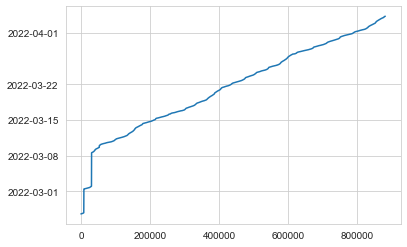

In [28]:
plt.plot(data_sample_all_n.index)

An diesem Plot erkennt man das der Zeitindex geordnet gelistet ist. Die lokalen Daten weisen schon diese Ordnung auf, da sie dahingehend verändert wurden. Die Rohdaten waren bezüglich ihrer Zeitindizes nicht geordnet.

### Verarbeitung der Daten <div id='verarbeitung-aller-daten'/>
Wir haben nun gesehen das es Zeitpunkte gibt zu denen der Ask-Preis einen Wert von "0" hat. Wir werden uns diese Zeitpunkte genauer anschauen.

In [29]:
data_sample_all_n[data_sample_all_n['a_price'] == 0]

,a_price,a_whole_lot_volume:Ask,a_lot_volume: Ask,b_price,b_whole_lot_volume: Bid,b_lot_volume: Bid,c_price,c_lot_volume: Close,v_today: Volume,v_24: Volume,p_today:,p_24,t_today,t_24,l_today,l_24,h_today,h_24,o_today,o_24
date,,,,,,,,,,,,,,,,,,,,
2022-03-16 00:37:43.685804+01:00,0.0,0.0,0.0,0.0,0.0,0.0,36026.1,0.001413,1579.048383,1585.899673,35631.59607,35634.23468,28233.0,28413.0,34803.8,34803.8,36394.8,36394.8,36268.2,36256.6
2022-03-16 00:37:46.655145+01:00,0.0,0.0,0.0,0.0,0.0,0.0,36026.1,0.001413,1579.048383,1585.899673,35631.59607,35634.23468,28233.0,28413.0,34803.8,34803.8,36394.8,36394.8,36268.2,36256.6


Hier sehen wir die selektierten Daten, die einen Ask-Preis von 0 haben.

In [30]:
data_sample_all_n = data_sample_all_n[data_sample_all_n['a_price'] > 0]

Jetzt haben wir alle Daten rausgefiltert die den Wert 0 beim Ask-Preis haben.
Im Folgenden plotten wir die nun bereinigten Daten.

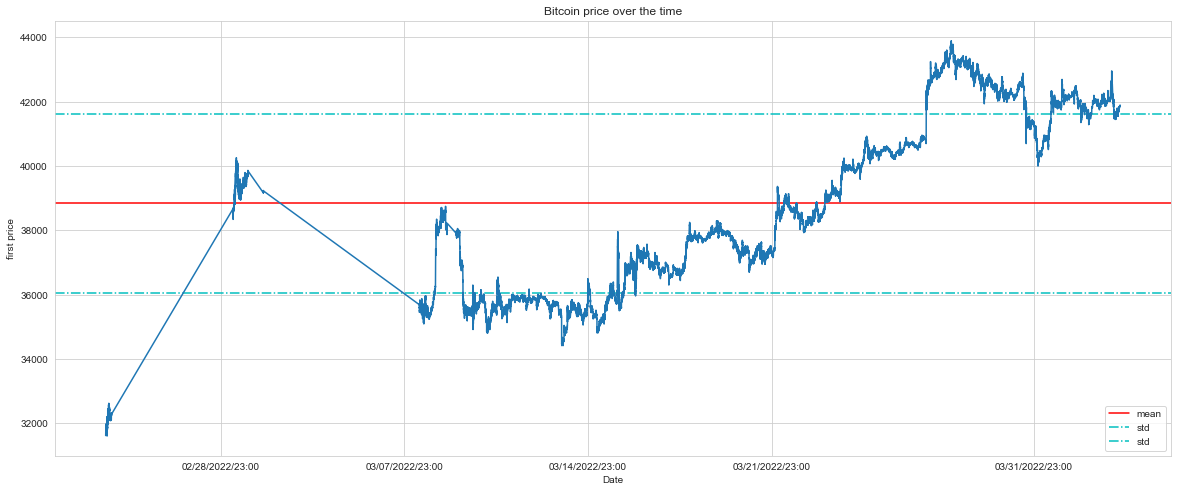

In [31]:
fig, ax = plt.subplots(figsize=(20,8))
x = data_sample_all_n.index
y = data_sample_all_n['a_price']
#data_sample_all[1].plot(label='first_price', legend=True, ax = ax)
plt.axhline(y=data_sample_all_mean.loc['mean'], c='r', label='mean')
plt.axhline(y=data_sample_all_mean.loc['mean']-data_sample_all_mean.loc['std'], c='c',linestyle='-.', label='std')
plt.axhline(y=data_sample_all_mean.loc['mean']+data_sample_all_mean.loc['std'], c='c',linestyle='-.', label='std')
plt.legend(loc='lower right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y/%H:%M'))
ax.set(xlabel="Date",
      ylabel="first price",
      title="Bitcoin price over the time")
plt.plot(x,y)

Jetzt wandeln wir die Daten in eine Zeitreihe von Pandas um, mit dem Ask-Preis als Spalte, damit wir später die Zeitreihenanalyse durchführen können.
Anschließend schauen wir uns an ob der Plot das gewünschte Ergebnis bringt.

In [32]:
first_price_ts = pd.Series(data_sample_all_n['a_price'])
first_price_ts

date
2022-02-24 14:27:03.226577+01:00    31623.8
2022-02-24 14:27:03.417405+01:00    31620.8
2022-02-24 14:27:11.516382+01:00    31629.4
2022-02-24 14:27:12.327173+01:00    31629.4
2022-02-24 14:27:14.762562+01:00    31619.5
                                     ...   
2022-04-04 08:12:44.047492+02:00    41869.5
2022-04-04 08:12:47.006623+02:00    41869.5
2022-04-04 08:12:47.019317+02:00    41869.5
2022-04-04 08:12:47.595969+02:00    41869.5
2022-04-04 08:12:47.608875+02:00    41869.5
Name: a_price, Length: 881837, dtype: float64

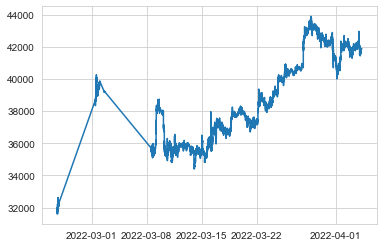

In [33]:
plt.plot(first_price_ts)

### Die letzten 1000 Werte <div id='letzten-1000'/>

Wir schauen uns die letzten 1000 Kurswerte kurz an.

In [34]:
size = len(first_price_ts)
first_price_1000_ts = first_price_ts[size-1000:size]
first_price_1000_ts

date
2022-04-04 07:45:48.308130+02:00    41858.9
2022-04-04 07:45:48.319298+02:00    41858.9
2022-04-04 07:45:51.574760+02:00    41858.9
2022-04-04 07:45:51.586111+02:00    41858.9
2022-04-04 07:45:54.130615+02:00    41858.9
                                     ...   
2022-04-04 08:12:44.047492+02:00    41869.5
2022-04-04 08:12:47.006623+02:00    41869.5
2022-04-04 08:12:47.019317+02:00    41869.5
2022-04-04 08:12:47.595969+02:00    41869.5
2022-04-04 08:12:47.608875+02:00    41869.5
Name: a_price, Length: 1000, dtype: float64

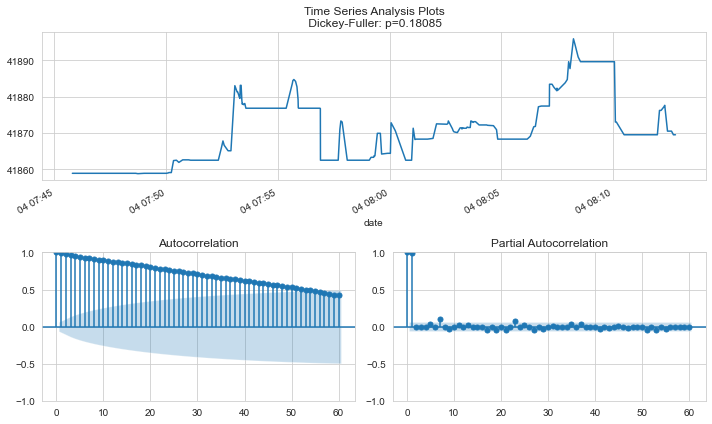

In [35]:
plot_general_acf_pacf_and_dickey(first_price_1000_ts)

Hier wurden der ACF- und PACF-Plot abgebildet und zudem der P-Wert des Dickey-Fuller-Test berechnet.
Der P-Wert ist in diesem Fall ungefähr 0.18 und damit wird die Null-Hypothese eines Random-Walk nicht verworfen und wir müssen laut diesem Test von einer Nicht-Stationären Zeitreihe ausgehen.

In [36]:
p_value = sm.tsa.stattools.adfuller(first_price_1000_ts)
p_value[1]

0.18085450031712857

Wir werden nun eine Decomposition für die Daten durchführen.

In [37]:
seasonal_decomposition = smt.tsa.seasonal.seasonal_decompose(first_price_1000_ts, model='multiplicable', period = 12)

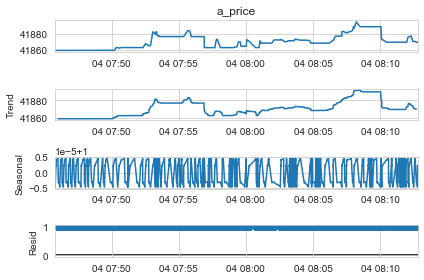

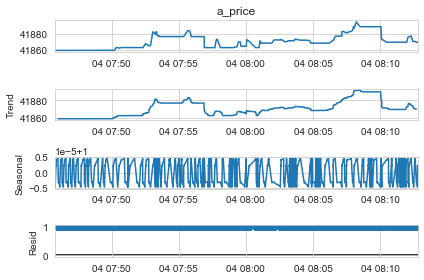

In [38]:
seasonal_decomposition.plot()

Das Ergebnis ist hier leider nicht wirklich befriedigend. Es stellt sich die Frage welchen Wert wir für die Periode nehmen sollen und mit einer willkürlichen Periode können wir leider auch keine seasonale Komponente rauslesen, die einen konstanten Abstand und damit eine gut erkennbare wiederholende Struktur hat. Wir werden später dennoch ein Modell finden, das eine seasonale Komponente hat.

### Preisänderungen <div id='preisänderung'/>
In diesem Abschnitt werden die Preisänderungen der Preise angeschaut.

In [39]:
price_diffs, price_diffs_perc = price_differences(data_sample_all_n)

In [40]:
data_sample_all_n['price_diff'] = price_diffs
data_sample_all_n['price_diff_perc'] = price_diffs_perc

In [41]:
size = len(data_sample_all_n['price_diff'])
price_diff_last_1000 = data_sample_all_n['price_diff'][size-1000:size]
seasonal_decomposition_price_diff_1000 = smt.tsa.seasonal.seasonal_decompose(price_diff_last_1000, model='additive', period = 12)
size = len(data_sample_all_n['price_diff_perc'])
price_diff_perc_last_1000 = data_sample_all_n['price_diff_perc'][size-1000:size]
seasonal_decomposition_price_diff_perc_1000 = smt.tsa.seasonal.seasonal_decompose(price_diff_perc_last_1000, model='additive', period = 12)

41732.19072
120.08021394650302


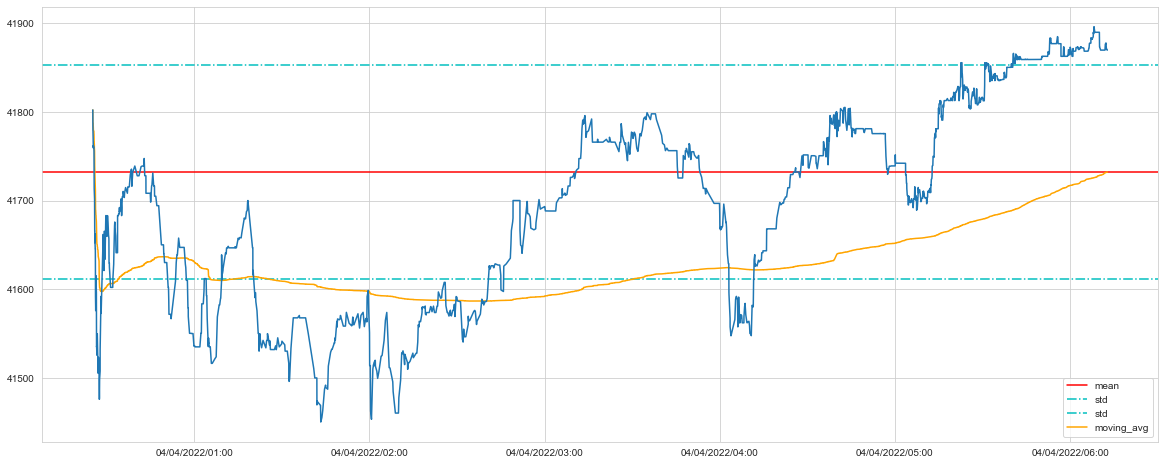

In [42]:
plot_data_moving_avg_std_data_frame(data_sample_all_n[size-5000:size], "a_price" , std_mult=1)

0.01348000000000029
5.07738695208987


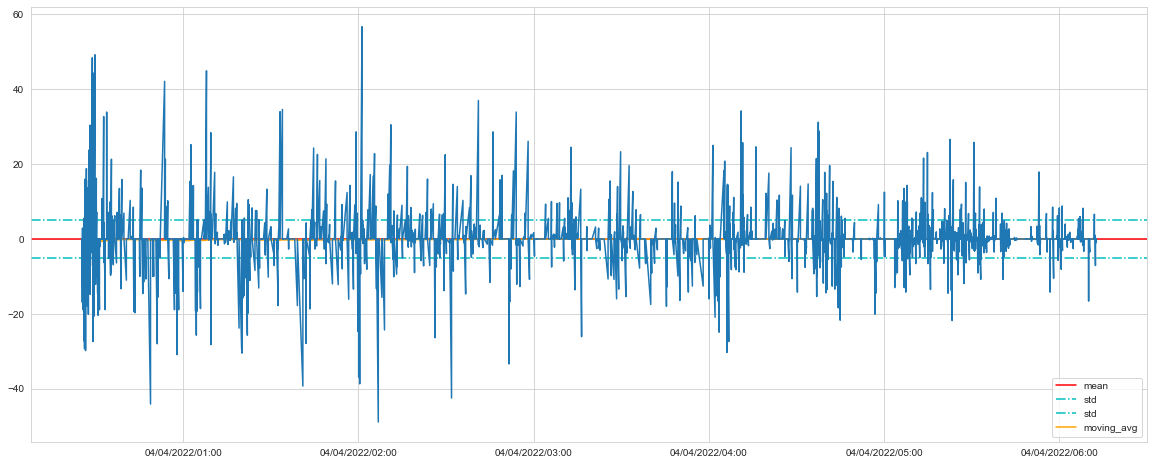

In [43]:
data_sample_all_n[size-5000:size]["price_diff"]

plot_data_moving_avg_std_data_frame(data_sample_all_n[size-5000:size], "price_diff", std_mult=1)

In [44]:

outliers = get_outliers(data_sample_all_n[size-5000:size],"price_diff" ,mu= 0.01348000000000029, sigma=5.07738695208987, n_sigmas=3)

date
2022-04-04 02:25:15.597458+02:00    0.0
2022-04-04 02:25:15.607605+02:00    0.0
2022-04-04 02:25:15.836360+02:00    0.0
2022-04-04 02:25:15.846278+02:00    0.0
2022-04-04 02:25:16.040739+02:00   -4.8
                                   ... 
2022-04-04 08:12:44.047492+02:00    0.0
2022-04-04 08:12:47.006623+02:00    0.0
2022-04-04 08:12:47.019317+02:00    0.0
2022-04-04 08:12:47.595969+02:00    0.0
2022-04-04 08:12:47.608875+02:00    0.0
Name: price_diff, Length: 5000, dtype: float64


0.01348000000000029
5.07738695208987


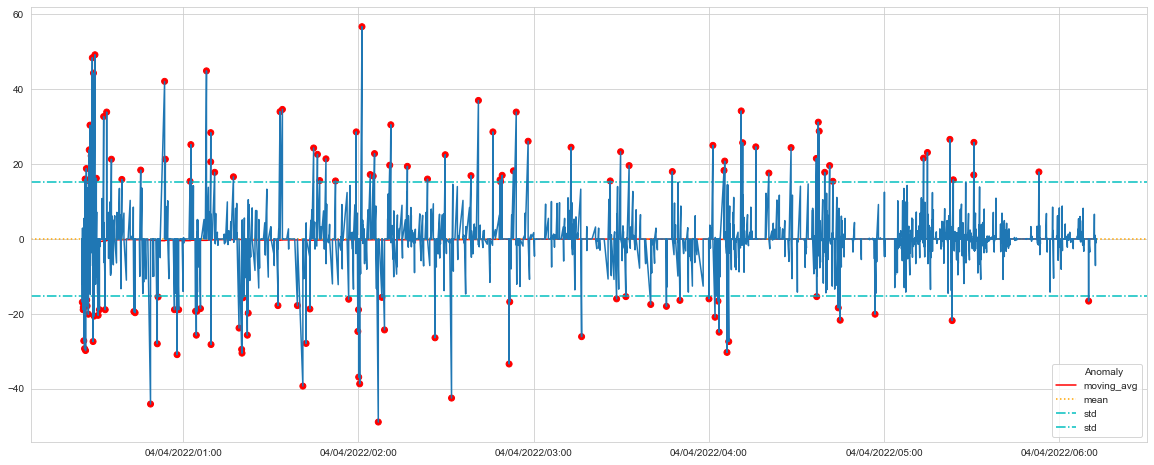

In [45]:
plot_data_moving_avg_std_ts(data_sample_all_n[size-5000:size]["price_diff"], outliers=outliers, std_mult=3)

Wir haben hier die Ausreiße in der Preisänderungen dargestellt. Diese wurden definiert als alle Werte, die um das Dreifache der Standardabweichung größer sind. Diese Grafik dient dazu einen Eindruck davon zu bekommen, wie die viele Daten stark von der Standardabweichung abweichen.
Wir werden aber in den Kapiteln der Zeitreihenanalyse die Daten nicht nach Outliers selektieren, da wir alle Informationen zu Preisen in der Analyse verarbeiten wollen.

### Zeitliche Lücken <div id='zeitliche-Lücken'/>
Wir werden uns jetzt den Datensatz auf die zeitlichen Lücken hin untersuchen. Idee ist dabei den Datensatz so zu selektieren, das wir möglichst große zusammenhängende Zeitreihendaten haben, die eine konstanten Zeitstempel haben. 

881837


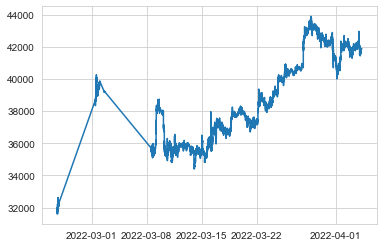

In [46]:

print(len(data_sample_all_n["a_price"]))
plt.plot(data_sample_all_n["a_price"])

Wenn wir uns die Zeitindizes der Zeitreihe anschauen sehen wir das diese nicht konstant sind und Lücken aufweisen, das heißt selbst nach dem wir die Microsekunden aus den Zeitindizes rausnehmen haben wir keine konstanten Abstände. Wir müssen diese Lücken identifizieren, denn für die spätere Arima Analyse empfiehlt es sich das die Zeitabstände konstant sind.


In [47]:
type(data_sample_all_n["a_price"])

pandas.core.series.Series

Der folgende Codeblock weist allen Indizes, die einen zeitlichen Abstand von mindestens einer Minute haben den Wert '0' zu. Dies dient dazu gleich eine Vorstellung von den zeitlichen Lücken von einer Minute und mehr zu bekommen.

In [48]:
all_a_price_data_ts = data_sample_all_n["a_price"]
n = len(all_a_price_data_ts.index)
index_to_drop = []
print(type(all_a_price_data_ts.index[0]))
new_index = []
new_values = []
print(n)
for i in range(n-1):
    d1 = (all_a_price_data_ts.index[i])
    d2 = (all_a_price_data_ts.index[i+1])
    if (abs(d2 - d1).total_seconds()) < timedelta(seconds=1*60).total_seconds():
        new_index.append(all_a_price_data_ts.index[i])
        new_values.append(all_a_price_data_ts[i])
    else:
        new_index.append(all_a_price_data_ts.index[i])
        new_values.append(0)

print(index_to_drop)
all_a_price_data_ts_filtered = pd.Series(index=new_index, data=new_values)
print(len(all_a_price_data_ts_filtered.index))

<class 'datetime.datetime'>
881837
[]
881836


881836


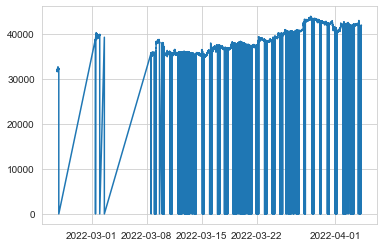

In [49]:
print(len(all_a_price_data_ts_filtered))
plt.plot(all_a_price_data_ts_filtered.index, all_a_price_data_ts_filtered)

Wir sehen jetzt alle Lücken von mindestens einer Minute. Wir erkennen dadurch das es wenig zusammenhängende Zeitreihendaten gibt, die einen zeitlichen Abstand von unter eine Minute haben.

Wir haben den Anspruch einen möglichst großen Teil von zusammenhängenden Daten zu analysieren. Man muss dabei beachten, das die Abstände zwischen den Daten nicht zu große sind, damit es noch ein zusammenhang der verschiedenen Zeitpunkten plausibel bleibt.
Hierbei spielt nicht nur die Dichte der Zeitpunkte eine Rolle, sondern auch der Zeitraum der durch die Zeitreihe abgedeckt wird.
Die Daten werden im folgenden Code für verschiedene Minuten Schritte (1,2,3,4,5) unterteilt und die längste Zeitreihe mit dem jeweils maximalen Zeitschritt wird für die verschiedenen Schritte ausgegeben.

In [50]:
all_a_price_data_ts = data_sample_all_n["a_price"]
n = len(all_a_price_data_ts.index)
index_to_drop = []
print(type(all_a_price_data_ts.index[0]))
new_index = []
new_values = []
print(n)
steps = [1,2,3,4,5]
ret = []
def transform_to_minute_steps(data, steps):
    ret = []
    for step in steps:
        for i in range(n-1):
            d1 = (data.index[i])
            d2 = (data.index[i+1])
            if (abs(d2 - d1).total_seconds()) < timedelta(seconds=1*60*step).total_seconds():
                new_index.append(data.index[i])
                new_values.append(data[i])
            else:
                new_index.append(data.index[i])
                new_values.append(0)
        all_a_price_data_ts_filtered = pd.Series(index=new_index, data=new_values)
        size = len(all_a_price_data_ts_filtered)
        list_of_series = []
        for h in range(size):
            if all_a_price_data_ts_filtered[h] == 0:
                temp_index_spline = []
                temp_value_spline = []
                begin = h + 1
                for begin in range(begin,size-1):
                    if all_a_price_data_ts_filtered[begin] == 0:
                        break
                    temp_index_spline.append(all_a_price_data_ts_filtered.index[begin])
                    temp_value_spline.append(all_a_price_data_ts_filtered[begin])
                temp_series = pd.Series(index=temp_index_spline,data=temp_value_spline)
                list_of_series.append((temp_series,len(temp_series)))
        max_series = max(list_of_series,key=lambda item:item[1])
        ret.append(max_series[0])
    return ret


<class 'datetime.datetime'>
881837


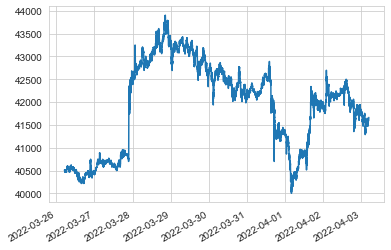

In [51]:

file = open("ts_minute_3.pickle","rb")
datas = pickle.load(file)
datas.plot()
for idx in steps:
    file = open("ts_minute_" + str(idx) + ".pickle", "rb")
    temp_ts = pickle.load(file)
    ret.append(temp_ts)

<AxesSubplot:>

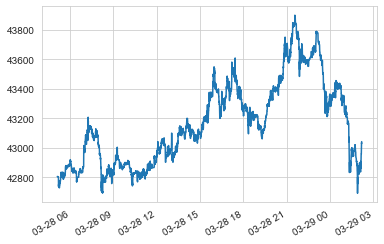

In [52]:
ret[0].plot()

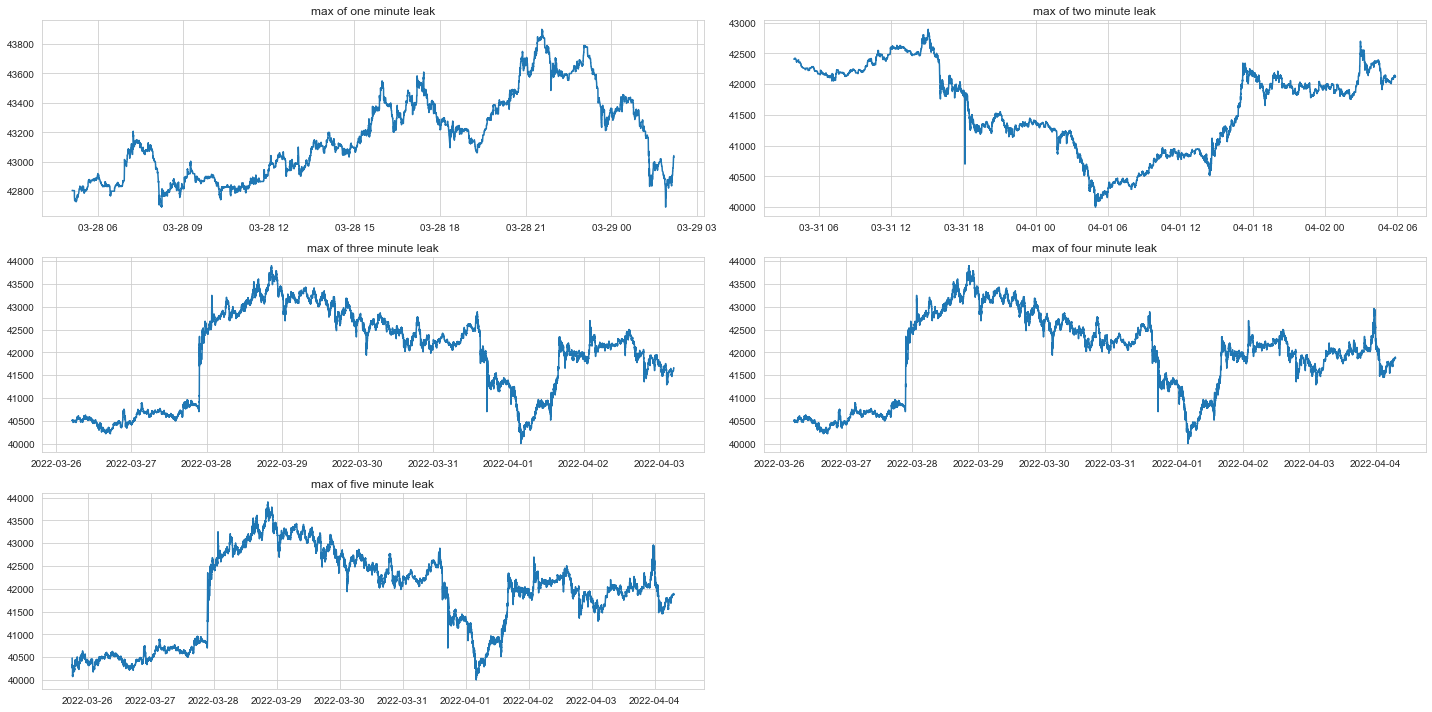

In [53]:

fig, axs = plt.subplots(3, 2,  figsize=(20, 10))

axs[0,0].plot(ret[0])
axs[0,0].set_title("max of one minute leak")
axs[0,1].plot(ret[1])
axs[0,1].set_title("max of two minute leak")
axs[1,0].plot(ret[2])
axs[1,0].set_title("max of three minute leak")
axs[1,1].plot(ret[3])
axs[1,1].set_title("max of four minute leak")
axs[2,0].plot(ret[4])
axs[2,0].set_title("max of five minute leak")
fig.delaxes(axs[2,1])
plt.tight_layout()
plt.show()


Wir erkennen das ab einer drei Minuten maximal Lücke der längste Zeitraum auf den ersten Blick gleich bleibt. Es lohnt sich daher die Zeitreihen mit einer, zwei und drei Minuten Lücke genauer anzuschauen.

## Arima Analyse <div id='arima-analyse'/>

Wir werden in den nächsten Abschnitten die jeweiligen Zeitreihen mit den maximalen Lücken genauer analysieren. Dazu werden wir immer die jeweiligen Zeitreihen immer so transformieren, dass wir einen konstanten Abstand der Zeitindizes haben, der dem der maximalen Lücke entspricht. Die Daten die innerhalb der konstanten Zeitabstände stehen werden durch ihren Durchschnitt ersetzt. Diese Transformation dienen dazu das wir eine Arima Analyse durchführen können, deren Ziel es ist eine Vorhersage zu machen und diese mit Testdaten zur vergleichen.
Zuerst werden wir kurz das Arima-Modell skizzieren.

### Arima-Modell <div id='arima-modell'/>

Das Arima Modell ist ein spezieller Fall eines Arma-Modells. Das Arma-Modell steht für AutoRegressive-Moving Average, soll einen stochastischen Prozess modellieren und besteht aus zwei Teilen. Ein Teil ist ein gleitendes Mittel (Moving Average) MA(q) und einem autoregressiven Teil (autoregressive) AR(p), . Die beiden Parameter q und p geben dabei die Ordnung des jeweiligen Teils an. Ein Arma-Modell setzt voraus das die Daten stationär sind. Stationarität bei einem stochastischen Prozess wird in eine starke und schwache Form unterteilt. Für die Zeitreihenanalyse reicht die schwache Form. Diese verlangt einen konstanten Erwartungswert, eine endliche Varianz und das die Autokovarianz sich nicht durch eine Verschiebung verändert. Durch Differenzierung kann eine Zeitreihe schwach stationär werden und damit durch ein Arma-Modell beschrieben werden.
Von einem Arima-Modell sprechen wir, wenn wir neben den Parametern p und q noch d für die Ordnung der Differenzierung haben. 

Im Folgenden sehen wir die Formel für das Arma Modell mit dem AR- und MA-Teil. 

<img src="Arima_p_q.PNG">

#### Differenzierung <div id='differenzierung'/>

Differenzierung ist eine Transformation von Zeitreihendaten, um diese Stationär zu machen. Dabei wird der Wert zu einem Zeitpunkt mit dem Wert des vorherigen Zeitpunktes subtrahiert. Man kann zudem mit dem Lag bestimmten, welchen Grad die Differenzierung hat, um Polynomen mit höheren Grad differenzieren zu können.

#### Tests <div id='tests'/>

Es werden in der Zeitreihenanalyse Tests auf Stationrität gemacht. Es wird dabei eine Reihe von Tests angewandt. Diese Testes sind:
 - Dickey-Fuller-Test (Nullhypthese: Random-Walk (Nicht-Stationär))
 - KPSS-Test (Nullhypthese: Stationarität )
 - PhillipsPerron Test (Nullhypothese: Random-Walk (Nicht-Stationär))

Wenn wir ein Arima-Modell erzeugt und gefittet haben, werden wir folgende Tests anwenden, um diese auf ihre Verteilung hin zu testen:
 - Ljung-Box-Test (Nullhypothes: Residuen sind unabhängig verteilt)
 - Shapiro-Wilk-Test (Nullhypothese: Residuen sind Normalverteilt) 

### Arima-Vorgehen <div id='arima-vorgehen'/>

Das Vorgehen eine Arima Analyse wird im Folgenden so aussehen:
 - Plotten von Zeitreihe und ACF- und PACF-Plot zusammen mit dem P-Wert vom Dickey-Fuller Test
 - Gegebenenfalls muss differenziert werden, wenn die Zeitreine nicht Stationär ist. Die Stationartät wird anhand des P-Wertes und weiteren Test sowie an dem Aussehen des ACF-Plotts erkannt.
 - Bestimmung von q und p
 - Erzeugung eine Arima-Modells (p,d,q) d = grad der Differenzierung

### Sarima-Modell <div id='sarima-modell'/>
Ein Sarima-Modell wird durch die Parameter (p,d,q) x (P,D,Q,s) bestimmt. Die kleingeschriebenen Parameter sind dabei die gewohnten Parameter für das Arima-Modell. Die großgeschriebenen Paramter sind die AR- und MA-Teile der saisonalen Struktur mit der saisonalen Spanne von s und der Ordnung der Differenzierung zum Lag s. Wir werden in den folgenden Analsen die Daten auf eine saisonale Komponente hin untersuchen. Erst im Abschnitt der drei Minuten Abstände werden wir einen Zuschnitt von Daten sehen der eine Sarima-Analyse erlaubt. 

### Sarima-Vorgehen <div id='sarima-vorgehen'/>

Das Vorgehen zur Erzeugung eines Sarima-Modells unterscheidet sich in der Logik nicht wesentlich von dem eines Arima-Modells, es müssen jetzt aber noch Analysen bezüglich der Parameter P,D und Q gemacht werden sowie das geeignete Lag s festgelegt werden.
 - Es wird eine Decomposition auf den Daten ausgeführt. Sollte eine saisonale Komponente erkennbar sein, kann ein Sarima-Modell angewandt werden.
 - Plotten von Zeitreihe und ACF- und PACF-Plot zusammen mit dem P-Wert vom Dickey-Fuller Test.
 - Gegebenenfalls muss saisonal zum Lag s differenziert werden, wenn die Zeitreine nicht Stationär ist. 
 - Danach wird gegebenfalls normal differenziert. 
 - Sollten die Test die Zeitreihe als stationär ausweisen, muss nicht mehr differenziert werden.
 - Es werden p und q anhand des PACF- und ACF-Plotts bestimmt.
 - Es werden P und Q anhand des PACF- und ACF-Plotts bestimmt. Dabei müssen wir immer von Lag 3 aus starten. 
 - Erzeugung des Sarima Modells mit (p,d,q) und seasonal_order = (P,D,Q,s)

### Eine Minute <div id='eine-minute'/>

#### [Plotten und Analyse](#plotten-eins)
#### [Modell und Vorhersage](#modell-eins)

#### Plotten und Analyse <div id='plotten-eins'/>

Wir betrachten kurz die Zeitreihe mit maximal eine Minute als Lücke und werden zuerst die Daten mit den ACF- und PACF-Plot darstellen.

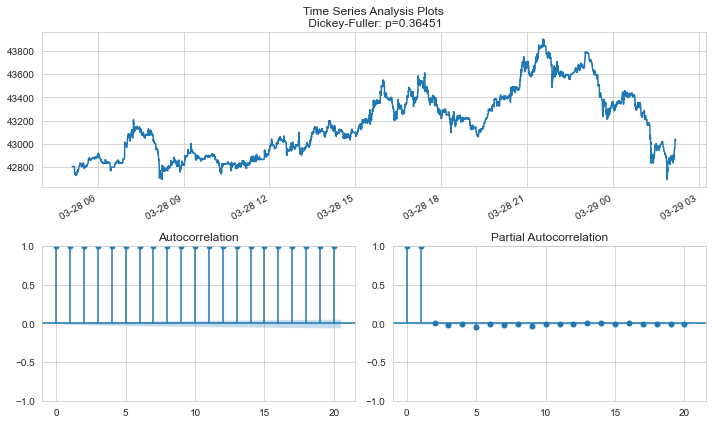

In [54]:
plot_general_acf_pacf_and_dickey(ret[0], lags=20)

Wir erkennen im ACF-Plot einen Random-Walk, was gegen die Stationarität spricht. Auch der Dickey-Fuller Test weist auf Nicht-Stationarität hin.

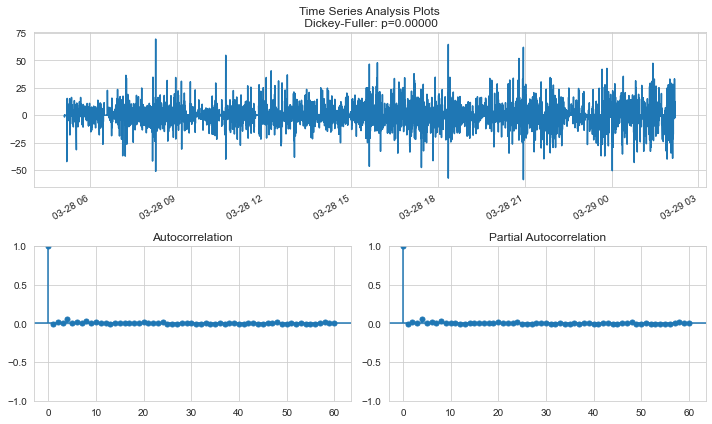

In [55]:
plot_general_acf_pacf_and_dickey(ret[0].diff()[1:len(ret[0])])

Nachdem wir einmal differenziert haben, bezüglich des Dickey-Fuller-Tests sehen wir die Ablehnung des Hypothese eines Random-Walk, was ein Hinweis auf Stationarität ist. 

Wir wollen hier einam die Anzahl der Daten in der 1 Minuten Zeitreihe sehen.

In [56]:
len(ret[0])

46373

Jetzt werden wir die Zeitreihe so transformieren, dass alle Daten 1 Minute Abstand zueinander haben, um so einen konstanten Abstand der Zeitindizes zu garantieren. Für die Daten, die innerhalb eines jeweiligen Zeitintervalls stehen, wird der Mittelwert gebildet.

In [ ]:
constant_1_minute_ts = constant_index_ts(ret[0],constant_second_step=0, constant_minute_step=1)

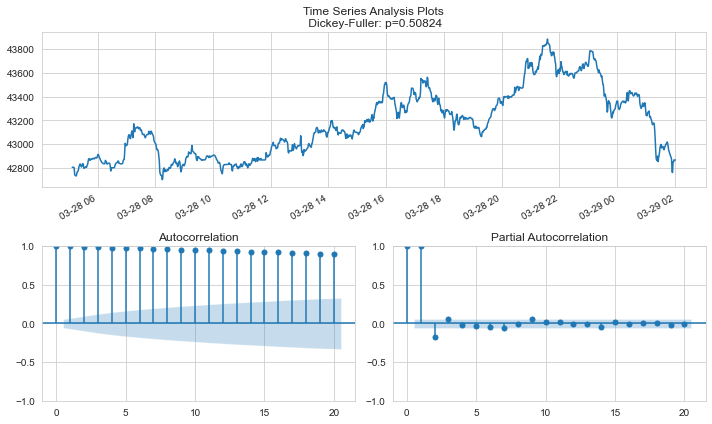

In [58]:
plot_general_acf_pacf_and_dickey(constant_1_minute_ts, lags=20)

In [59]:
len(constant_1_minute_ts)

1255

Wie erwartet ist die Zeitreihe nicht stationär. Wir werden jetzt eine Differenzierung durchführen und die letzten 100 Daten wegnehmen um sie später mit der Prognose zu vergleichen.

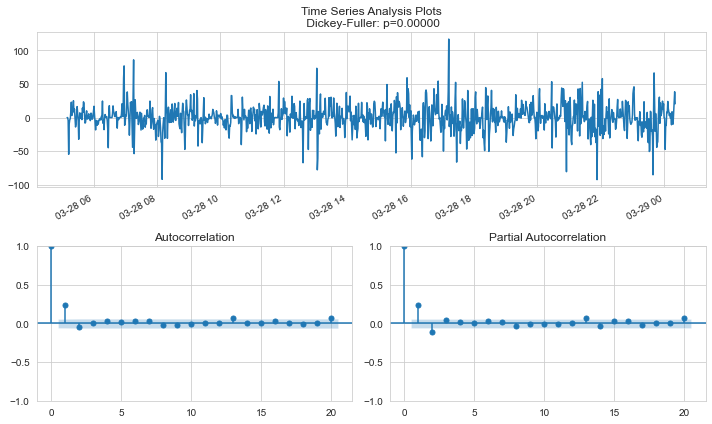

In [60]:
constant_1_minute_ts_train = constant_1_minute_ts[1:len(constant_1_minute_ts)-100]
constant_1_minute_ts_diff_train = constant_1_minute_ts_train.diff()[1:len(constant_1_minute_ts_train)]
plot_general_acf_pacf_and_dickey(constant_1_minute_ts_diff_train, lags=20)

wir sehen das jetzt laut Dickey-Fuller Stationarität vorliegt und wenden weitere Tests darauf an.

In [61]:
get_tests_for_stationarity(constant_1_minute_ts_diff_train)

Dickey-Fuller Test
Dickey-Fuller Statistic: -18.343837665809097
p-value: 2.2433489915258645e-30
Result: The series is  stationary
KPSS Test
KPSS Statistic: 0.04802700553616813
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
PhillipsPerron Test
     Phillips-Perron Test (Z-tau)    
Test Statistic                -26.719
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Die weiteren Tests deuten auch auf Stationarität hin. Diese werden wir im Weiterem für diese Zeitreihe annehmen. Wir werden nach dem ACF- und PACF-Plot zwei Modelle für Arima nutzen, p=3, q=1 und p=2 und q=1.

In [62]:
constant_1_minute_ts_train = constant_1_minute_ts[0:len(constant_1_minute_ts)-100]

#### Modell und Vorhersage <div id='modell-eins'/>

In [63]:
constant_1_minute_ts_diff_train_arima_311 = ARIMA(constant_1_minute_ts_train, order=(3,1,1), freq="T")
constant_1_minute_ts_diff_train_arima_211 = ARIMA(constant_1_minute_ts_train, order=(2,1,1), freq="T")

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


Die Warnung kann ignoriert werden, da die gewünschte Frequency von T (=eine Minute) gewählt wurde und auch übergeben wurde. Diese Warnung wird sich für die weiteren Modelle wiederholen und kann dort aus der äquivalenten Argumentation ignoriert werden.

Jetzt werden wir das Arima-Modell fitten und uns die Summary des Modells anschauen.

In [64]:
constant_1_minute_ts_diff_train_arima_311_fit = constant_1_minute_ts_diff_train_arima_311.fit(start_params=[0,0,0,0,1])
constant_1_minute_ts_diff_train_arima_311_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1155
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -5014.219
Date:                Thu, 01 Sep 2022   AIC                          10038.438
Time:                        19:43:41   BIC                          10063.693
Sample:                    03-28-2022   HQIC                         10047.969
                         - 03-29-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8869      0.311      2.852      0.004       0.277       1.496
ar.L2         -0.2760      0.087     -3.186      0.001      -0.446      -0.106
ar.L3          0.1032      0.034      3.019      0.003       0.036       0.170
ma.L1         -0.6242      0.313     -1.995      0.046      -1.238      -0.011
sigma2       347.8760      8.649     40.224      0.000     330.925     364.827
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               679.10
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Die Summary zeigt das Ergebnis des Fittings und gibt deren Konfidenzintervall an sowie weitere Informationen. Es werden Zudem die Werte des Informationskritierien angezeigt. Für diese gilt sollten zwei Modell den gleichen Datensatz beschreiben, so das Modell vorzuziehen, welches die kleinsten Werte bezüglich seiner Informationskriterien hat.

In [65]:
constant_1_minute_ts_diff_train_arima_211_fit = constant_1_minute_ts_diff_train_arima_211.fit(start_params=[0,0,0,1])
constant_1_minute_ts_diff_train_arima_211_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1155
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -5014.930
Date:                Thu, 01 Sep 2022   AIC                          10037.860
Time:                        19:43:41   BIC                          10058.064
Sample:                    03-28-2022   HQIC                         10045.485
                         - 03-29-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0056      0.235      0.024      0.981      -0.456       0.467
ar.L2         -0.0457      0.066     -0.692      0.489      -0.175       0.084
ma.L1          0.2581      0.237      1.089      0.276      -0.206       0.722
sigma2       348.4011      8.576     40.626      0.000     331.593     365.209
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               689.34
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Die beiden Arima-Modelle unterscheiden sich nicht stark bezüglich der Informationskriterien wobei 211 jeweils kleinere Werte diesbezüglich hat und daher grundsätzlich vorzuziehen ist.

In [66]:
get_tests_for_residuals(constant_1_minute_ts_diff_train_arima_311_fit.resid)

Ljung-Box-Test
Ljung-Box-Test Statistic: 6.474717796301258
Ljung-Box-Test P-Value: 1.0
Result: The residuals are   identical independent distributed
Shapiro-Wilk-Test
Shapiro-Wilk-Test Statistic: 0.0136946439743042
Shapiro-Wilk-Test P-Value: 0.0
Result: The residuals are not normal independent distributed 


In [67]:
get_tests_for_residuals(constant_1_minute_ts_diff_train_arima_211_fit.resid)

Ljung-Box-Test
Ljung-Box-Test Statistic: 6.487644798026376
Ljung-Box-Test P-Value: 1.0
Result: The residuals are   identical independent distributed
Shapiro-Wilk-Test
Shapiro-Wilk-Test Statistic: 0.013696491718292236
Shapiro-Wilk-Test P-Value: 0.0
Result: The residuals are not normal independent distributed 


Es wurden für die Residuen beider Modelle Tests angewandt. Der Ljung-Box-Test gibt darüber Auskunft, ob die Residuen des Modells unabhängig verteilt (id) sind. Das ist eine wichtige Voraussetzung für die Residuen, denn sollten die Residuen kein id Rauschen aufweisen, wären noch Strukturen vorhanden, die nicht vom Modell abgedeckt wären. Die Null-Hypothese ist, dass die Residuen id sind. Die Alternative Hypothese ist, das die Residuen nicht id sind. Der Shapiro-Wilk-Test wird dazu verwendet, um zu testen ob die Residuen unabhängig und normal verteilt sind. Diese Eigenschaft ergänzt id um die Normalverteilung. Man kann auch ohne dieser Eigenschaft mit einem Modell weiterarbeiten. 

Für beide Modell ergibt der Ljung-Box-Test das die Residuen id sind, was das gewünschte Ergebnis ist. Das in beiden Modellen die Residuen nicht normalverteilt sind, ist kein Problem und wir können mit beiden Modellen arbeiten.

Jetzt wird das die Vorhersage für das Modell mit den Parametern (3,1,1) für die nächsten 10 Zeitschritte berechnet und in einem Plot dargestellt.

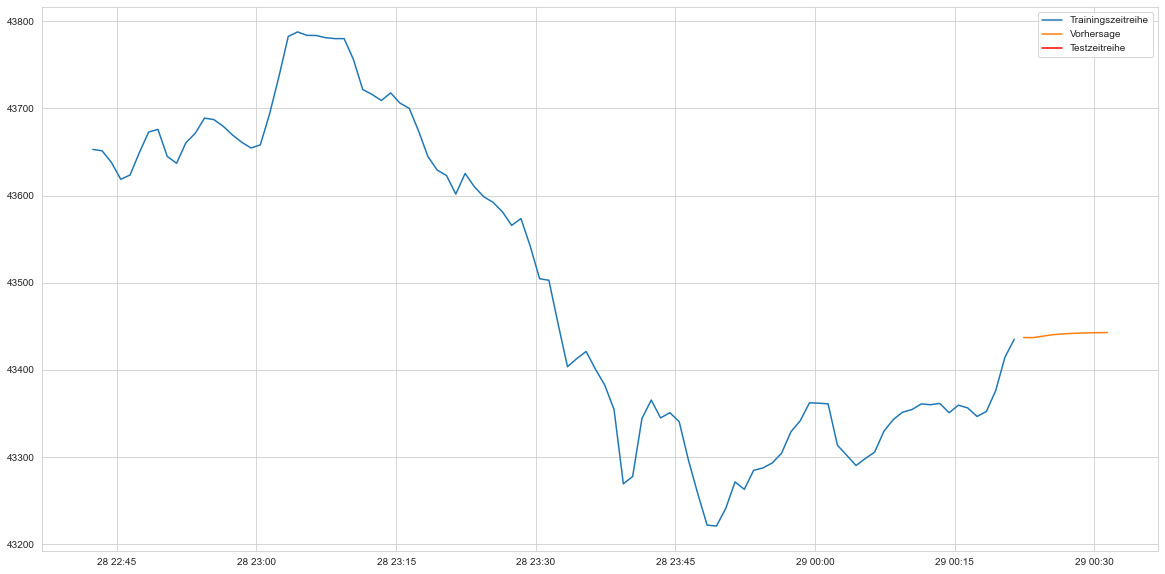

In [68]:
fig = plt.figure(figsize=(20,10))
constant_1_minute_ts_diff_train_arima_311_fit_forecast = constant_1_minute_ts_diff_train_arima_311_fit.forecast(steps=10)
plt.plot(constant_1_minute_ts_train[len(constant_1_minute_ts_train)-100:len(constant_1_minute_ts_train)], label="Trainingszeitreihe")
plt.plot(constant_1_minute_ts_diff_train_arima_311_fit_forecast, label="Vorhersage")
plt.plot(constant_1_minute_ts[len(constant_1_minute_ts)-10:len(constant_1_minute_ts)-90], color="red",label="Testzeitreihe")
plt.legend(loc="upper right")
plt.show()

Jetzt wird das die Vorhersage für das Modell mit den Parametern (3,1,2) für die nächsten 10 Zeitschritte berechnet und in einem Plot dargestellt.

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


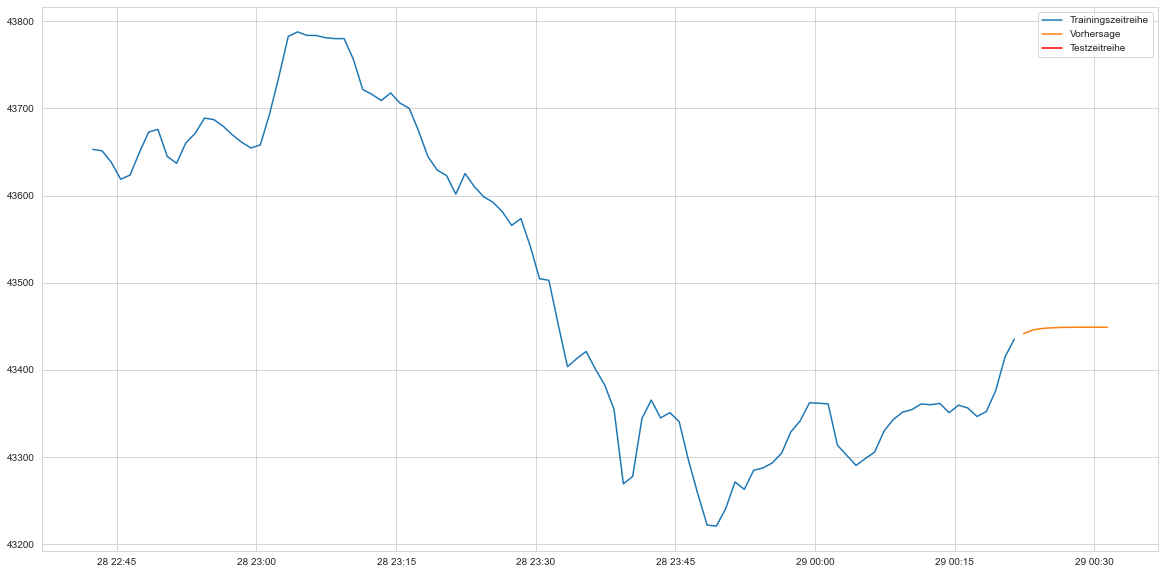

In [69]:

constant_1_minute_ts_diff_train_arima_312 = ARIMA(constant_1_minute_ts_train[len(constant_1_minute_ts_train)-300:len(constant_1_minute_ts_train)],order=(3,1,1), freq="T")
constant_1_minute_ts_diff_train_arima_312_fit = constant_1_minute_ts_diff_train_arima_312.fit()
constant_1_minute_ts_diff_train_arima_312_fit.summary()

fig = plt.figure(figsize=(20,10))
constant_1_minute_ts_diff_train_arima_312_fit_forecast = constant_1_minute_ts_diff_train_arima_312_fit.forecast(steps=10)
plt.plot(constant_1_minute_ts_train[len(constant_1_minute_ts_train)-100:len(constant_1_minute_ts_train)], label="Trainingszeitreihe")
plt.plot(constant_1_minute_ts_diff_train_arima_312_fit_forecast, label="Vorhersage")
plt.plot(constant_1_minute_ts[len(constant_1_minute_ts)-10:len(constant_1_minute_ts)-90], color="red", label="Testzeitreihe")
plt.legend(loc="upper right")
plt.show()

Jetzt werden wir die beiden Modell mit Vorhersage für 100 Zeitschritt und der Prediction des vergangenen Werte im Vergleich zu den Trainingsdaten und den Testdaten darstellen. Wir beginnen wieder mit dem Modell (3,1,1).

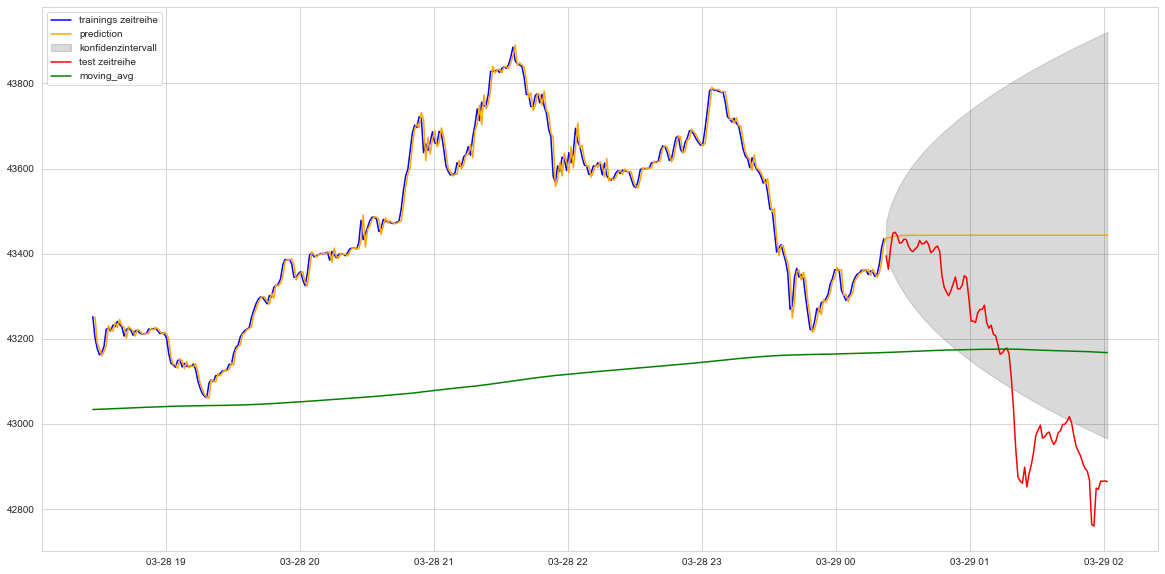

In [70]:
prediction_with_confidence(constant_1_minute_ts_diff_train_arima_311_fit, train_ts=constant_1_minute_ts_train, data_ts=constant_1_minute_ts, start= constant_1_minute_ts_train.index[1], end=constant_1_minute_ts.index[len(constant_1_minute_ts)-1])

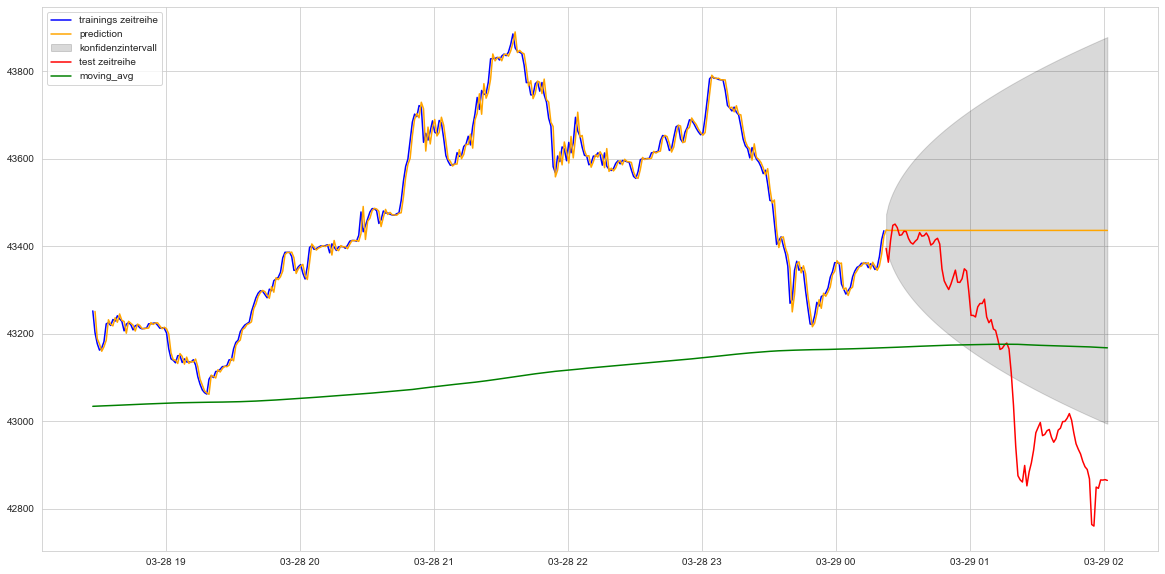

In [71]:
prediction_with_confidence(constant_1_minute_ts_diff_train_arima_211_fit, train_ts=constant_1_minute_ts_train, data_ts=constant_1_minute_ts, start= constant_1_minute_ts_train.index[1], end=constant_1_minute_ts.index[len(constant_1_minute_ts)-1])

Die beiden Modelle unterscheiden sich nicht stark voneinander. Wir sehen das in den ersten Zeitschritten der Vorhersage zumindest bessere Ergebnisse erreicht werden als im späteren Verlauf. Im späteren Verlauf weicht die Vorhersage beider Modelle stark von den Testdaten ab.

### Zwei Minuten <div id='zwei-minuten'/>
In diesem Abschnitt werden wir uns die Zeitreihe mit 2 Minuten als maximale Lücke der Zeitindizes anschauen und diese zu einer Zeitreihe mit konstanten zwei Minuten Abstand transformieren, um auf ihr Arima Analysen zu machen. 

#### [Plotten und Analyse](#plotten-zwei)
#### [Modell und Vorhersage](#modell-zwei)

#### Plotten und Analyse <div id='plotten-zwei'/>

In diesem Codeblock wird die Zeitreihe so transformiert, das sie einen konstanten Zeitabstand von 2 Minuten hat.

In [ ]:
constant_2_minute_ts = constant_index_ts(ret[1],constant_second_step=0, constant_minute_step=2)

Jetzt werden wir uns die Zeitreihe und den ACF- und PACF-Plot ausgeben lassen. 

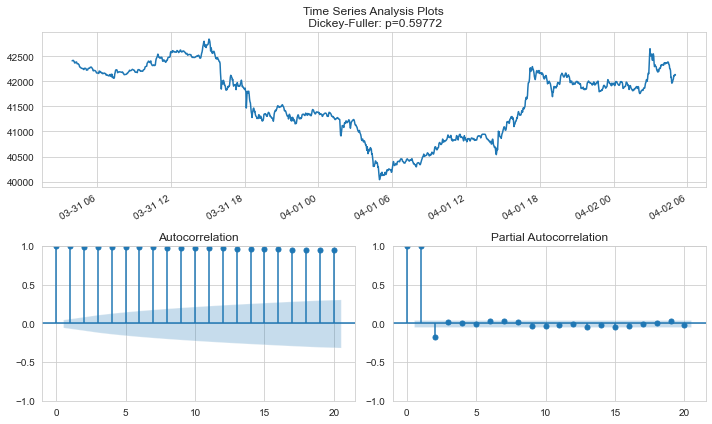

In [73]:

plot_general_acf_pacf_and_dickey(constant_2_minute_ts, lags=20)

Der Dickey-Fuller-Test und der ACF-Plot weisen auf Nicht-Stationarität hin. Wir werden nun die anderen Test auf die Zeitreihe anwenden.

In [74]:
get_tests_for_stationarity(constant_2_minute_ts)

Dickey-Fuller Test
Dickey-Fuller Statistic: -1.3675697803867226
p-value: 0.5977210863471762
Result: The series is not stationarystationary
KPSS Test
KPSS Statistic: 1.5080267840976669
p-value: 0.01
num lags: 25
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
PhillipsPerron Test
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.402
P-value                         0.582
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Wie erwartet haben liegt keine Stationarität laut jedem Test vor.

In [75]:
len(constant_2_minute_ts)

1473

Wir werden jetzt die Daten in ein Testdatensatz und Trainingsdatensatz aufsplitten. Der Trainingsdatensatz hat 1373 Werte, der Testdatensatz 100. Wir werden den Trainingsdatensatz differnzieren, da wir wegen der vorherigen Analysen nicht davon ausgehen das er stationär ist.

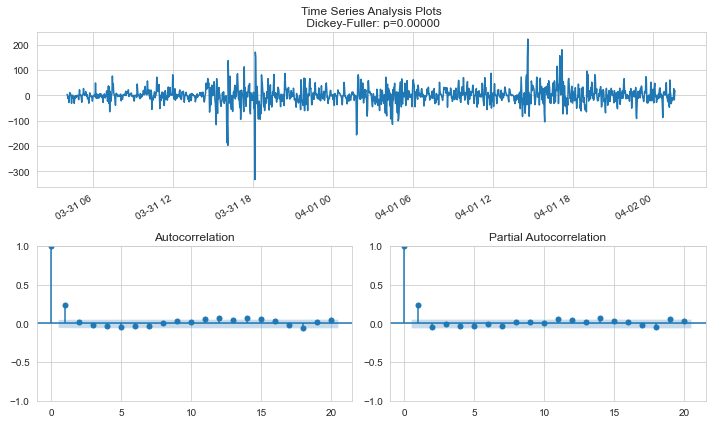

In [76]:
constant_2_minute_ts_train = constant_2_minute_ts[1:len(constant_2_minute_ts)-100]
constant_2_minute_ts_train_diff = constant_2_minute_ts_train.diff()[1:len(constant_2_minute_ts_train)]
plot_general_acf_pacf_and_dickey(constant_2_minute_ts_train_diff, lags=20)

Wir schauen uns jetzt nochmal an, ob wir eine seasonale Sturktur rauslesen können.

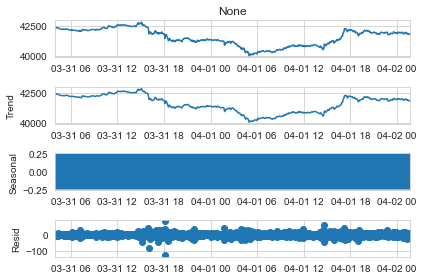

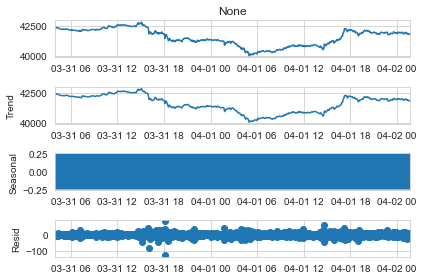

In [77]:
constant_2_minute_ts_train_decom = smt.tsa.seasonal.seasonal_decompose(constant_2_minute_ts_train,model='additive', period = 2)
constant_2_minute_ts_train_decom.plot()

Wir können leider wieder keine Strutkur seasonaler Art erkennen.

<AxesSubplot:>

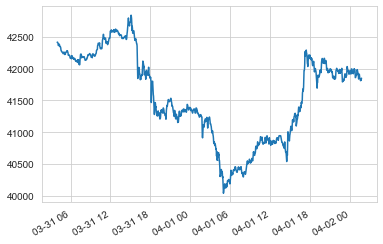

In [78]:
constant_2_minute_ts_train.plot()

Wir testen hier nochmal mit mehreren Test, ob der Trainingsdatensatz nach einer Differenzierung stationär ist.

In [79]:
get_tests_for_stationarity(constant_2_minute_ts_train_diff)

Dickey-Fuller Test
Dickey-Fuller Statistic: -23.845568482726087
p-value: 0.0
Result: The series is  stationary
KPSS Test
KPSS Statistic: 0.354078974784675
p-value: 0.0969487177652263
num lags: 2
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
PhillipsPerron Test
     Phillips-Perron Test (Z-tau)    
Test Statistic                -28.971
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Wir sehen das nach einer Differenzierung die Zeitreihe stationär wird. Wir wählen als Arima Modell daher p=3, q=2, d=1. Eigentlich hätten man hier auch q = 1 wählen können, nach dem Artikel [Arima Analyse](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/) wird unter Punkt 8 empfohlen bei Überdifferenzierung einen weiteren MA-Prozess zum Arima Modell hinzuzunehmen.

In [80]:
constant_2_minute_ts_train = constant_2_minute_ts[0:len(constant_2_minute_ts)-100]

#### Modell und Vorhersage <div id='modell-zwei'/> 

Jetzt wird das Modell erstellt und gefittet. Wir werden uns dann kurz die Summary anschauen.

In [81]:
constant_2_minute_ts_diff_train_arima_312 = ARIMA(constant_2_minute_ts_train, order=(3,1,2), freq="2T")
constant_2_minute_ts_diff_train_arima_312_fit = constant_2_minute_ts_diff_train_arima_312.fit(start_params=[0,0,0,0,0,1])
constant_2_minute_ts_diff_train_arima_312_fit.summary()

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2T will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   None   No. Observations:                 1373
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -6737.007
Date:                Thu, 01 Sep 2022   AIC                          13486.015
Time:                        19:43:54   BIC                          13517.359
Sample:                    03-31-2022   HQIC                         13497.744
                         - 04-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0975      0.203     -0.481      0.631      -0.495       0.300
ar.L2         -0.7971      0.183     -4.349      0.000      -1.156      -0.438
ar.L3          0.1967      0.052      3.772      0.000       0.094       0.299
ma.L1          0.3402      0.203      1.676      0.094      -0.058       0.738
ma.L2          0.8716      0.179      4.871      0.000       0.521       1.222
sigma2      1078.5534     16.131     66.862      0.000    1046.937    1110.170
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):             10883.03
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.18
Prob(H) (two-sided):                  0.23   Kurtosis:                        16.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Der Vergleich von Informationskriterien macht am meisten für Modell auf den gleichen Datensatz Sinn. Da wir hier nur ein Modell aufgestellt ist, müssen wir die Informationskritierien nicht genauer betrachten.

In [82]:
get_tests_for_residuals(constant_2_minute_ts_diff_train_arima_312_fit.resid[1:len(constant_2_minute_ts_train_diff)])

Ljung-Box-Test
Ljung-Box-Test Statistic: 1087.8827309623184
Ljung-Box-Test P-Value: 0.9999999962360719
Result: The residuals are   identical independent distributed
Shapiro-Wilk-Test
Shapiro-Wilk-Test Statistic: 0.8812894821166992
Shapiro-Wilk-Test P-Value: 4.048679490701012e-31
Result: The residuals are not normal independent distributed 


Die Test auf die Residuen des Modells zeigen das wir zumindest von eine id Verteilung ausgehen können.

Wir schauen uns jetzt an wie eine Prediction auf die Vergangenen Werte und die Vorhersage für die 100 Testdaten aussieht und plotten dies zusammen mit den Gleitenden Mittel und den Testdaten.

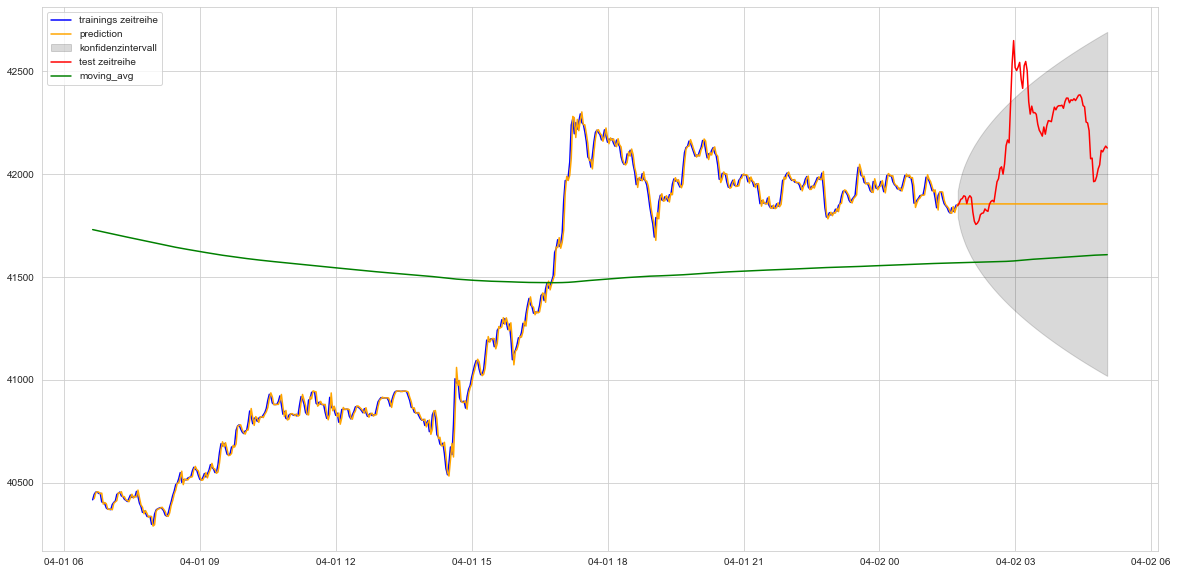

In [83]:
prediction_with_confidence(constant_2_minute_ts_diff_train_arima_312_fit,train_ts=constant_2_minute_ts_train, data_ts=constant_2_minute_ts,start=constant_2_minute_ts_train.index[1], end=constant_2_minute_ts.index[len(constant_2_minute_ts)-1], dynamic=False)

Hier wurde die Prediction für die Trainingsdaten und der Forecast für die zukünftigen Werte berechnet. Wir sehen das für den vergangenen Zeitraum die Zeitreihe relativ gut vorhergesagt werden kann. Die Vorhersage schein vorallem am Anfang besser zu sein als später, daher schauen wir uns diese im Vergleich zu den ersten 10 Testdaten genauer an.

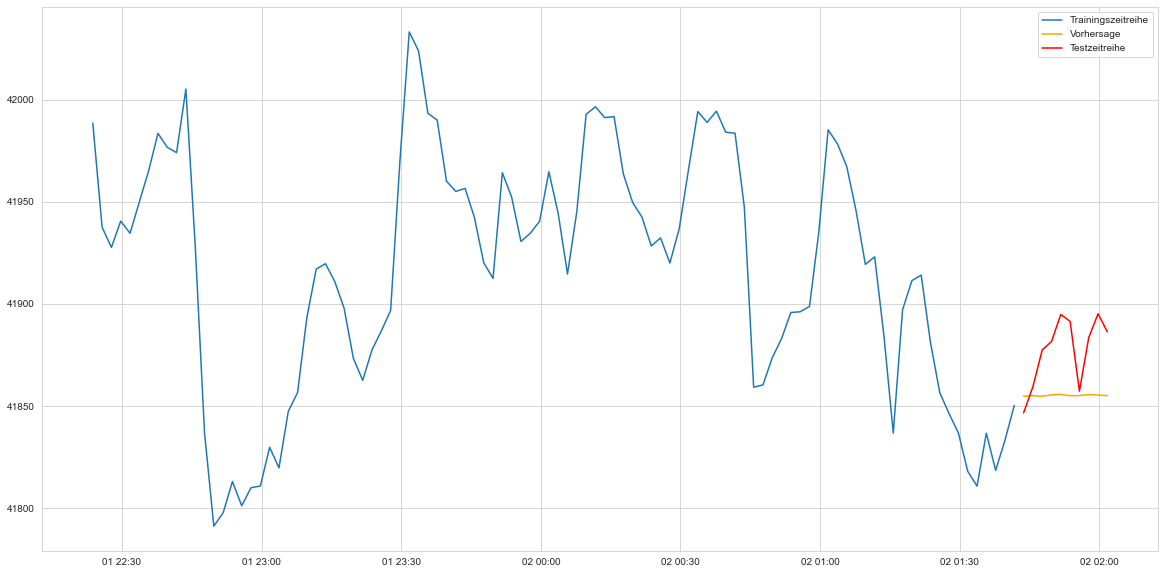

In [84]:
fig = plt.figure(figsize=(20,10))
constant_2_minute_ts_diff_train_arima_312_fit_forecast = constant_2_minute_ts_diff_train_arima_312_fit.forecast(steps=10)
plt.plot(constant_2_minute_ts_train[len(constant_2_minute_ts_train)-100:len(constant_2_minute_ts_train)], label="Trainingszeitreihe")
plt.plot(constant_2_minute_ts_diff_train_arima_312_fit_forecast, color = "orange", label="Vorhersage")
plt.plot(constant_2_minute_ts[len(constant_2_minute_ts)-100:len(constant_2_minute_ts)-90], color="red", label="Testzeitreihe")
plt.legend(loc="upper right")
plt.show()

Hier sehen wir das im Vergleich zu den Testwerten der Forecast für diesen Zeitraum den positiven Trend nicht gut vorhersagen konnte,  aber im Vergleich zu den späteren Zeitpunkten der Unertschied noch nicht so stark ist.

### drei Minuten <div id='drei-minuten'/>

#### [Plotten und Analyse](#plotten-drei)
#### [Modell und Vorhersage](#modell-drei)
#### [Saisonales Arima Modell](#saisonal-drei)

#### Modell und Vorhersage <div id='plotten-drei'/>
Die ersten Schritte sind wie vorher die Transformation des Datensatzes und danach plotten wir die Daten mit ACF- und PACF-Plot und dem P-Wert des Dickey-Fuller-Tests.

In [ ]:
constant_3_minute_ts = constant_index_ts(ret[2],constant_second_step=0, constant_minute_step=3)

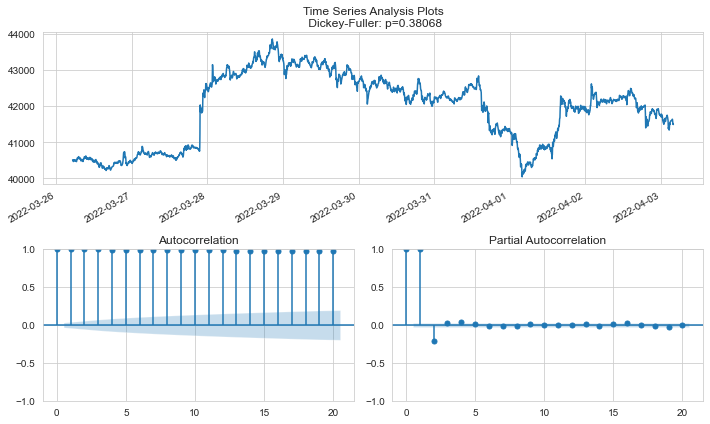

In [86]:
plot_general_acf_pacf_and_dickey(constant_3_minute_ts, lags=20)

In [87]:
get_tests_for_stationarity(constant_3_minute_ts)

Dickey-Fuller Test
Dickey-Fuller Statistic: -1.7995506519907698
p-value: 0.3806848052324732
Result: The series is not stationarystationary
KPSS Test
KPSS Statistic: 1.6287334899750454
p-value: 0.01
num lags: 39
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
PhillipsPerron Test
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.792
P-value                         0.384
Lags                               30
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Wir sehen das die Test alle Stationarität ablehnen und werden daher einmal differenzieren.

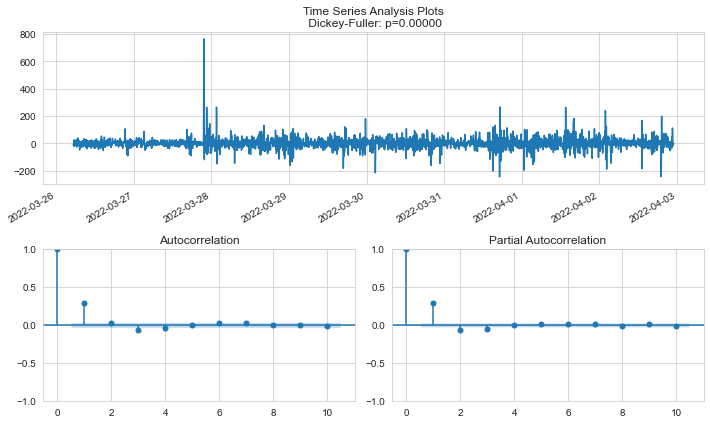

In [88]:
constant_3_minute_ts_train = constant_3_minute_ts[1:len(constant_3_minute_ts)-100]
constant_3_minute_ts_train_diff = constant_3_minute_ts_train.diff()[1:len(constant_3_minute_ts_train)]
plot_general_acf_pacf_and_dickey(constant_3_minute_ts_train_diff, lags=10)

In [89]:
get_tests_for_stationarity(constant_3_minute_ts_train_diff)

Dickey-Fuller Test
Dickey-Fuller Statistic: -34.70268036636872
p-value: 0.0
Result: The series is  stationary
KPSS Test
KPSS Statistic: 0.19269212007352304
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
PhillipsPerron Test
     Phillips-Perron Test (Z-tau)    
Test Statistic                -44.116
P-value                         0.000
Lags                               30
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Wir sehen hier das nach eine Differenzierung zum Lag 1 wir nach diesen Tests eine stationäre Zeitreihe haben.

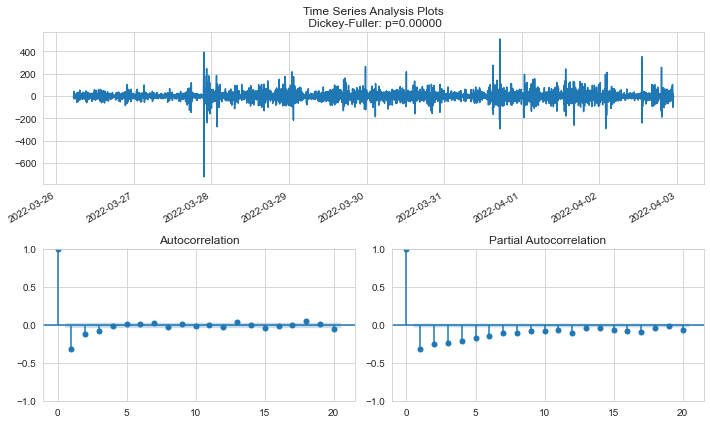

In [90]:
constant_3_minute_ts_train_diff_diff = constant_3_minute_ts_train_diff.diff()[1:len(constant_3_minute_ts_train_diff)]
plot_general_acf_pacf_and_dickey(constant_3_minute_ts_train_diff_diff, lags=20)

Hier wurde ein weiteres Mal differenziert. Die Vielen negativen PACF-Werte sind ein Hinweis auf Überdifferenzierung. Abgesehen davon haben wir die Stationarität schon nach einmaligen differenzieren erreicht. Wir wählen für das Modell die Parameter p=2, q=1 und d=1.

#### Modell und Vorhersage <div id='modell-drei'/>
Wir werden zuerst das Modell erstellen und dann fitten.

In [91]:
constant_3_minute_ts_diff_train_arima_211 = ARIMA(constant_3_minute_ts_train, order=(2,1,1), freq="3T")
constant_3_minute_ts_diff_train_arima_211_fit = constant_3_minute_ts_diff_train_arima_211.fit( start_params=[0,0,0,1])
constant_3_minute_ts_diff_train_arima_211_fit.summary()

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3T will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   None   No. Observations:                 3717
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -18648.744
Date:                Thu, 01 Sep 2022   AIC                          37305.489
Time:                        19:44:03   BIC                          37330.370
Sample:                    03-26-2022   HQIC                         37314.341
                         - 04-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7243      0.107      6.778      0.000       0.515       0.934
ar.L2         -0.1938      0.029     -6.773      0.000      -0.250      -0.138
ma.L1         -0.4158      0.108     -3.849      0.000      -0.628      -0.204
sigma2      1338.0890      8.640    154.878      0.000    1321.156    1355.022
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            220553.48
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             2.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
get_tests_for_residuals(constant_3_minute_ts_diff_train_arima_211_fit.resid[1:len(constant_3_minute_ts_train_diff)])

Ljung-Box-Test
Ljung-Box-Test Statistic: 3205.5165450975514
Ljung-Box-Test P-Value: 0.9999999996896055
Result: The residuals are   identical independent distributed
Shapiro-Wilk-Test
Shapiro-Wilk-Test Statistic: 0.8278644680976868
Shapiro-Wilk-Test P-Value: 0.0
Result: The residuals are not normal independent distributed 


Wir sehen, dass die Residuen des Modells die wichtige id Bedingung erfüllen.
Jetzt werden wir wieder eine Prediction auf die vergangenen Werte berechnen und dann für die Vorhersage für die 100 Testdatensätze und diese mit den Testdaten zu vergleichen.

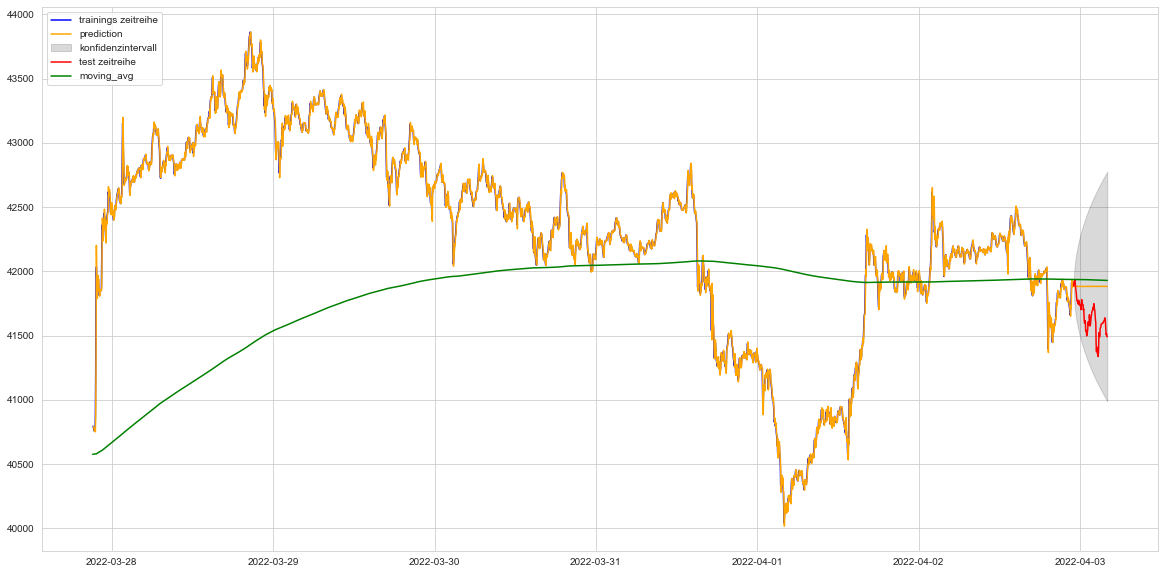

In [93]:
prediction_with_confidence(constant_3_minute_ts_diff_train_arima_211_fit,train_ts=constant_3_minute_ts_train, data_ts=constant_3_minute_ts,start=constant_3_minute_ts_train.index[1], end=constant_3_minute_ts.index[len(constant_3_minute_ts)-1], dynamic=False)

 Wir sehen, dass die Vorhersage für die ersten Zeitschritte besser ist als für die späteren und sehen wir wieder eine gute Approximation der vergangenen Werte. Wir werden uns die Vorhersage genauer anschauen.
Wir werden das auf nächsten 10 Zeitschritte begrenzen.

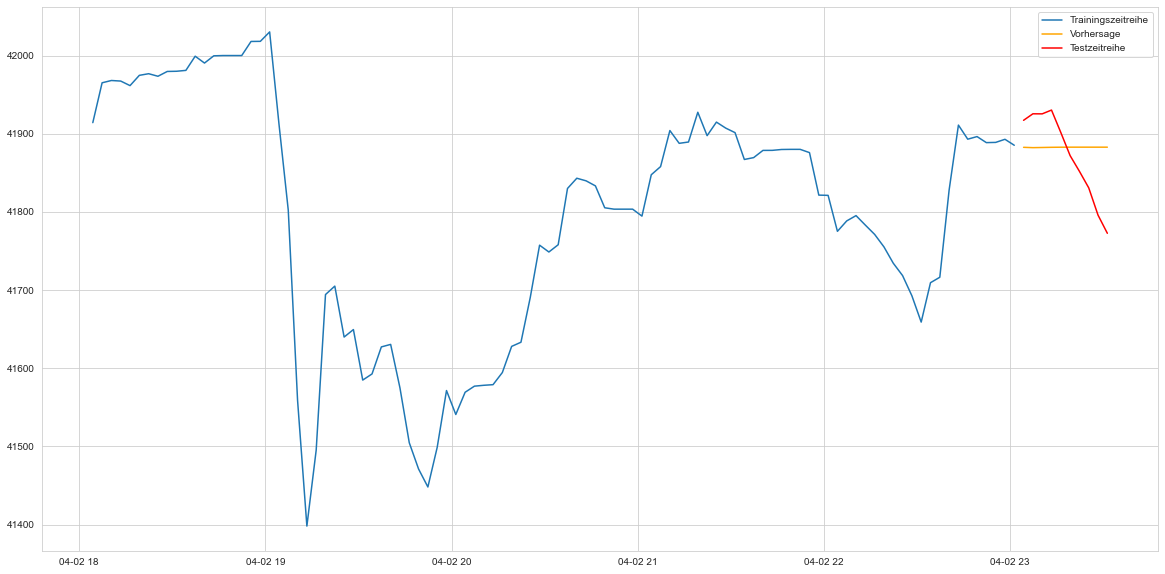

In [94]:
fig = plt.figure(figsize=(20,10))
constant_3_minute_ts_diff_train_arima_211_fit_forecast = constant_3_minute_ts_diff_train_arima_211_fit.forecast(steps=10)
plt.plot(constant_3_minute_ts_train[len(constant_3_minute_ts_train)-100:len(constant_3_minute_ts_train)], label="Trainingszeitreihe")
plt.plot(constant_3_minute_ts_diff_train_arima_211_fit_forecast, color = "orange", label="Vorhersage")
plt.plot(constant_3_minute_ts[len(constant_3_minute_ts)-100:len(constant_3_minute_ts)-90], color="red", label="Testzeitreihe")
plt.legend(loc="upper right")
plt.show()

Hier sehen wir das der Trend der Testdaten nicht richtig erkannt wird, dennoch die Abweichung der Vorhersage zu den Testdaten im Vergleich zu den späteren Zeitschritten noch nicht so groß ist und zu einem Zeitpunkt Vorhersage und Testdatenpunkt sogar identisch sind. Wir schauen uns jetzt an, ob es eine saisonale Struktur zu erkennen ist.

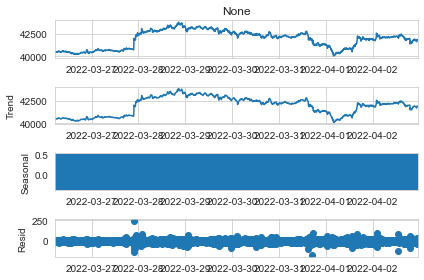

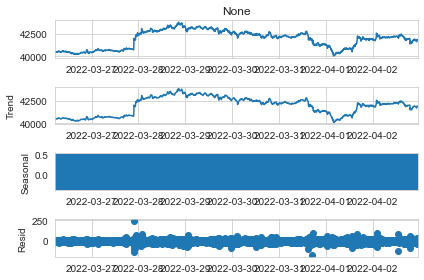

In [95]:
constant_3_minute_ts_train_decom =  smt.tsa.seasonal.seasonal_decompose(constant_3_minute_ts_train,model='additive', period = 3)
constant_3_minute_ts_train_decom.plot()

Wir erkennen leider auch keine sinnvolle seasonale Struktur. 

Wir werden im Folgenden eine andere Aufteilung von Test- und Trainingsdaten unternehmen um zu testen, ob die Modelle generell einen Trend erkennen können. Wir werden anschließend dieselben Schritte unternehmen wie in den Abschnittend davor.

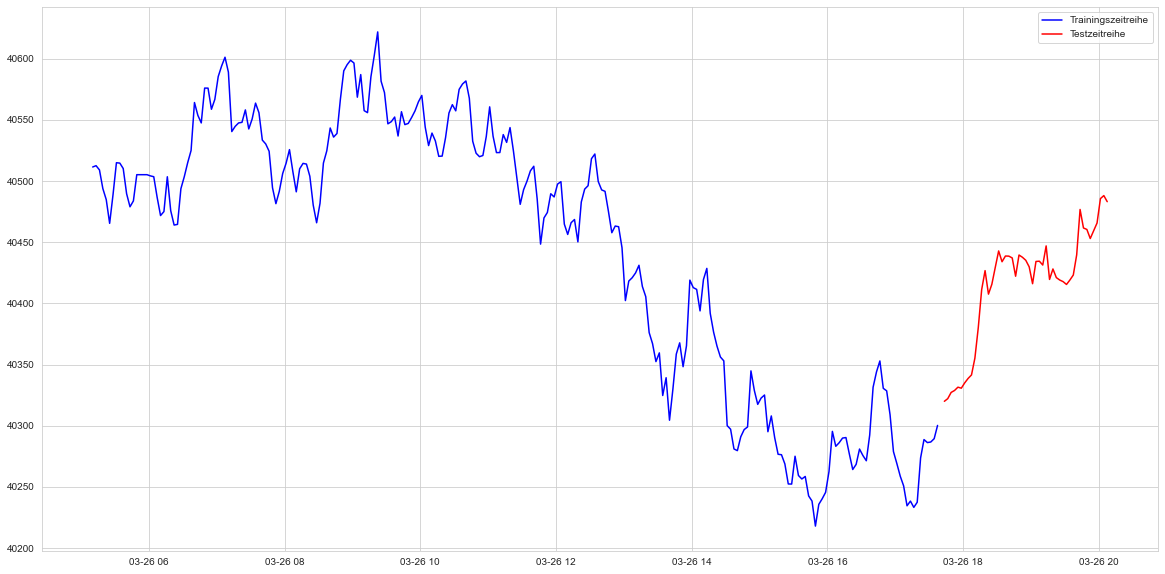

In [96]:
fig = plt.figure(figsize=(20,10))
constant_3_minute_ts_trend = constant_3_minute_ts[0:300]
constant_3_minute_ts_trend_train = constant_3_minute_ts_trend[0:250]
constant_3_minute_ts_trend_test = constant_3_minute_ts_trend[251:300]
plt.plot(constant_3_minute_ts_trend_train,color="blue", label="Trainingszeitreihe")
plt.plot(constant_3_minute_ts_trend_test, color="red", label="Testzeitreihe")
plt.legend(loc="upper right")
plt.show()

Wir haben im vorherigen Plot die neue Aufteilung der Test- und Trainingsdaten geplottet. Die Trainingsdaten beinhalten die ersten 250 Daten der ursrpünglichen Zeitreihe und die Testdaten die darauffolgenden 49  Daten.

In [97]:
get_tests_for_stationarity(constant_3_minute_ts_trend_train)

Dickey-Fuller Test
Dickey-Fuller Statistic: -1.1331412832626688
p-value: 0.7016762682463284
Result: The series is not stationarystationary
KPSS Test
KPSS Statistic: 1.8860705543247493
p-value: 0.01
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
PhillipsPerron Test
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.761
P-value                         0.830
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Die Test lehnen Stationarität ab. Wir werden uns dennoch erstmal die Daten mit dem ACF und PACF-Werten plotten lassen.

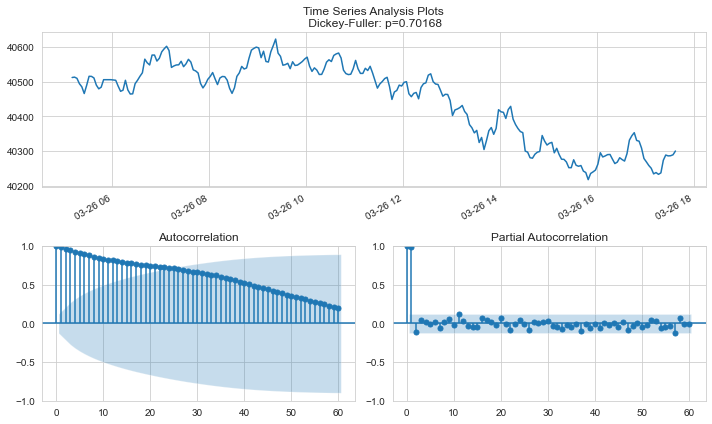

In [98]:
plot_general_acf_pacf_and_dickey(constant_3_minute_ts_trend_train)

#### Saisonales Arima Modell <div id='saisonal-drei'/>
In diesem Abschnitt werden wir sehen das der 3 Minuten Datensatz eine saisonale Komponente hat und ein Saisonales Arima (SARIMA) Modell darauf anwenden. Dabei werden wir wie beschrieben das Sarima-Vorgehen verwenden.

Wir werden jetzt eine Decomposisition auf die neu aufgeteilten Trainingsdaten berechnen.

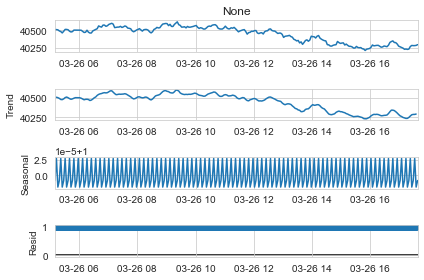

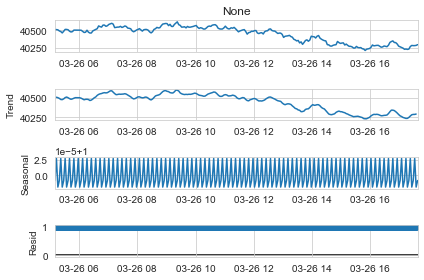

In [99]:
constant_3_minute_ts_trend_train_decom =  smt.tsa.seasonal.seasonal_decompose(constant_3_minute_ts_trend_train,model='multiplicable', period = 3)
constant_3_minute_ts_trend_train_decom.plot()

Jetzt erkennen wir eine sinnvolle saisonale Struktur, die wir für unser Modell ausnutzen können.

In [ ]:
constant_3_minute_ts_trend_train

Wir werden uns kurz anschauen was passiert, wenn wir zurerst mit dem Lag 1 differenzieren.

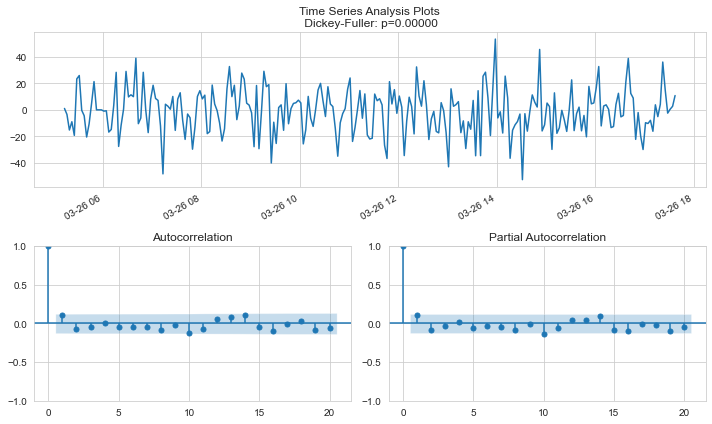

In [101]:
constant_3_minute_ts_trend_train_diff = constant_3_minute_ts_trend_train.diff()
constant_3_minute_ts_trend_train_diff = constant_3_minute_ts_trend_train_diff[1:len(constant_3_minute_ts_trend_train_diff)]
plot_general_acf_pacf_and_dickey(constant_3_minute_ts_trend_train_diff, lags=20)

Hier haben wir wieder das klassische Resultat, wenn wir einmal differenzieren, da diese Struktur wieder sehr ähnlich zu vorangegangenen Modellen wäre gehen wir davon aus das wir allein damit keine nennenswerten Ergebnisse erzielen. Wir werden jetzt einmal seasonal differenzieren und danach einmal zum lag 1 differenzieren um zu schauen, ob wir mehr Informationen aus den Daten nehmen können.

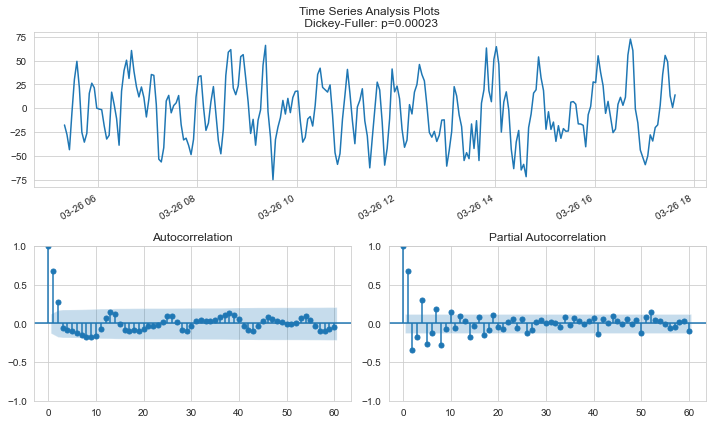

In [102]:
constant_3_minute_ts_trend_train_diff_season = constant_3_minute_ts_trend_train.diff(periods=3)
constant_3_minute_ts_trend_train_diff_season = constant_3_minute_ts_trend_train_diff_season[3:len(constant_3_minute_ts_trend_train_diff_season)]
plot_general_acf_pacf_and_dickey(constant_3_minute_ts_trend_train_diff_season)

In [103]:
get_tests_for_stationarity(constant_3_minute_ts_trend_train_diff_season)

Dickey-Fuller Test
Dickey-Fuller Statistic: -4.457344870276041
p-value: 0.00023464446191010332
Result: The series is  stationary
KPSS Test
KPSS Statistic: 0.10221694861118413
p-value: 0.1
num lags: 5
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
PhillipsPerron Test
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -5.499
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Nachdem saisonalen Differenzieren haben wir nach den Tests Stationrität erreicht und werden jetzt einamal zum Lag 1 differzieren.

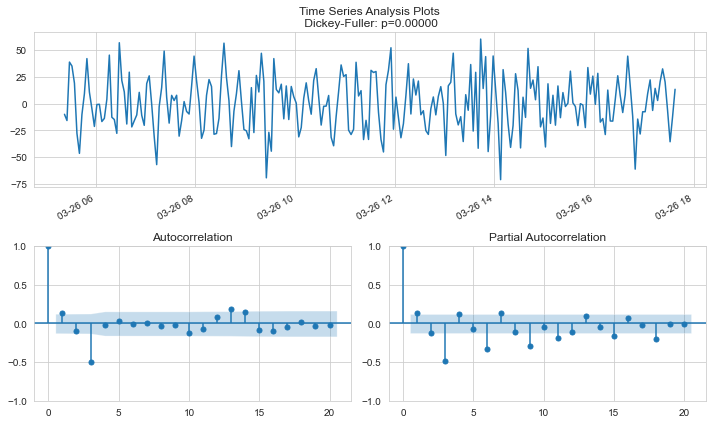

In [104]:
constant_3_minute_ts_trend_train_diff_season_diff = constant_3_minute_ts_trend_train_diff_season.diff()
constant_3_minute_ts_trend_train_diff_season_diff = constant_3_minute_ts_trend_train_diff_season_diff[1:len(constant_3_minute_ts_trend_train_diff_season)]
plot_general_acf_pacf_and_dickey(constant_3_minute_ts_trend_train_diff_season_diff, lags=20)

Wir werden für die normale Ordnung p =2, q = 2 und d = 1 wählen und für die seasonale Ordnung ab Lag 3 uns den Acf- und Pacf-Graphen anschauen. Für die seasonale Ordnug wählen wir P = 2 und Q = 1 und D = 1 zur Periode 3.

In [105]:
constant_3_minute_ts_trend_211_seas_211 = ARIMA(constant_3_minute_ts_trend_train, order=(2,1,0), seasonal_order=(2,1,0,3), freq="3T")
constant_3_minute_ts_trend_211_seas_211_fit = constant_3_minute_ts_trend_211_seas_211.fit(start_params=[0,0,0,0,1])
constant_3_minute_ts_trend_211_seas_211_fore = constant_3_minute_ts_trend_211_seas_211_fit.forecast(steps=50)


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3T will be used.
  self._init_dates(dates, freq)


In [106]:
constant_3_minute_ts_trend_211_seas_211_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                            None   No. Observations:                  250
Model:             ARIMA(2, 1, 0)x(2, 1, 0, 3)   Log Likelihood               -1084.798
Date:                         Thu, 01 Sep 2022   AIC                           2179.597
Time:                                 19:44:15   BIC                           2197.124
Sample:                             03-26-2022   HQIC                          2186.654
                                  - 03-26-2022                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1952      0.067      2.913      0.004       0.064       0.327
ar.L2         -0.0631      0.071     -0.888      0.375      -0.202       0.076
ar.S.L3       -0.6888      0.065    -10.610      0.000      -0.816      -0.562
ar.S.L6       -0.3593      0.069     -5.236      0.000      -0.494      -0.225
sigma2       394.0625     36.125     10.908      0.000     323.260     464.865
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.95   Prob(JB):                         0.85
Heteroskedasticity (H):               1.40   Skew:                            -0.08
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
get_tests_for_residuals(constant_3_minute_ts_trend_211_seas_211_fit.resid)

Ljung-Box-Test
Ljung-Box-Test Statistic: 41.20468317227883
Ljung-Box-Test P-Value: 1.0
Result: The residuals are   identical independent distributed
Shapiro-Wilk-Test
Shapiro-Wilk-Test Statistic: 0.06970828771591187
Shapiro-Wilk-Test P-Value: 4.058825138361921e-33
Result: The residuals are not normal independent distributed 


Wir sehen hier das die Informationskriterien deutlich kleiner sind als alle Bisherigen, der Vergleich macht aber nur für Modelle auf den gleichen Datensatz Sinn.

Wir werden jetzt wie gewohnt die Prediction auf die vergagenen Werte berechnen und die Testdaten mit der Vorhersage vergleichen.

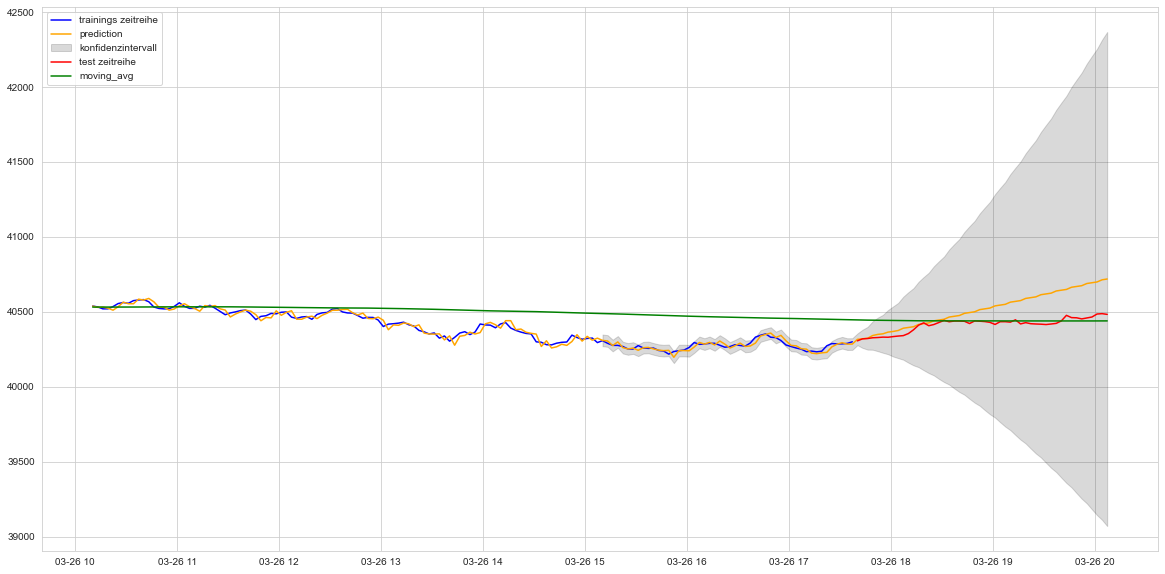

In [108]:
prediction_with_confidence(constant_3_minute_ts_trend_211_seas_211_fit,train_ts=constant_3_minute_ts_trend_train, data_ts=constant_3_minute_ts_trend,start=constant_3_minute_ts_trend_train.index[0],end=constant_3_minute_ts_trend.index[len(constant_3_minute_ts_trend)-1],start_plot=100 )

Wir werden uns jetzt einen einen kleineren Datenausschnitt betrachten, um das Resultat besser zu verstehen. Dennoch kann man jetzt schon erkennen, dass am Anfang der Trend relativ gut von der Vorhersage beschrieben werden kann, später die Vorhersage aber sich von den Testdaten entkoppelt. 

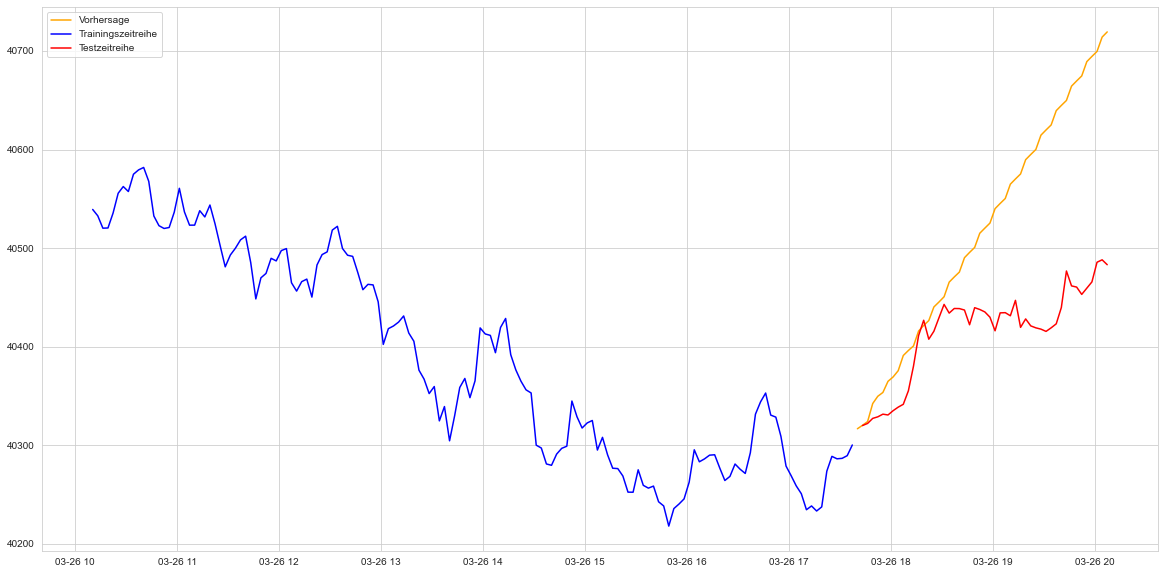

In [109]:
fig = plt.figure(figsize=(20,10))
plt.plot(constant_3_minute_ts_trend_211_seas_211_fore, color="orange", label="Vorhersage")
plt.plot(constant_3_minute_ts_trend_train[100:250],color="blue", label="Trainingszeitreihe")
plt.plot(constant_3_minute_ts_trend_test[0:50], color="red",label="Testzeitreihe")
plt.legend(loc="upper left")
plt.show()

Wir sehen zwar eine sehr starke Abweichung von den Testdaten, aber wir erkennen das, dass Modell die Testdaten für die ersten Schritte relativ gut approximiert und den Trend gut vorhersagt. Für die weiteren Schritte führt das Modell den positiven Trend weiter fort und weicht daher stark von den Testdaten ab.
Wir wollen es im Folgendem dem Modell ein bisschen einfacher machen und zeigen das grundsätzlich gute Vorhersagen möglich sind so fern, es keine Trendwende gibt. Daher teilen wir die Trainings- und Testdaten nochmal auf. Diese neue Aufteilung dient nur dazu zu zeigen das es für Zeitreihen ohne Trendwende die Prognose besser verläuft. Für eine eine relativ kurzen Zeitraum waren die bisherigen Vorsagen besser als für die späteren Zeitrräume. 

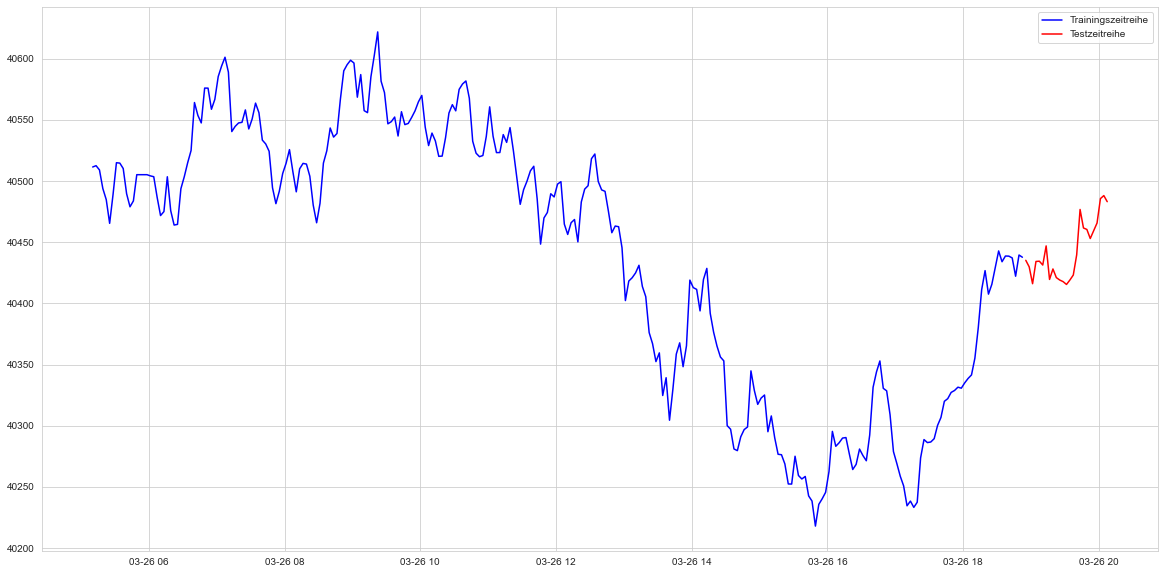

In [110]:
fig = plt.figure(figsize=(20,10))
constant_3_minute_ts_trend = constant_3_minute_ts[0:300]
constant_3_minute_ts_trend_train_temp = constant_3_minute_ts_trend[0:275]
constant_3_minute_ts_trend_test_temp = constant_3_minute_ts_trend[275:300]
plt.plot(constant_3_minute_ts_trend_train_temp,color="blue", label="Trainingszeitreihe")
plt.plot(constant_3_minute_ts_trend_test_temp, color="red",label="Testzeitreihe")
plt.legend(loc="upper right")
plt.show()

Die Trainingsdaten sind jetzt die ersten 275 Daten und die Testdaten die letztn 25 Daten.

Wir werden uns jetzt die Decomposition der neuen Traingsdaten anschauen.

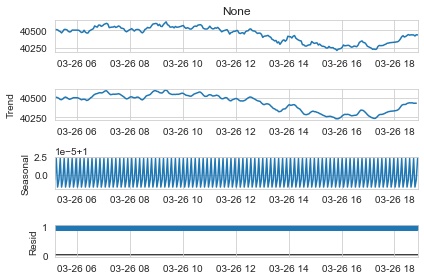

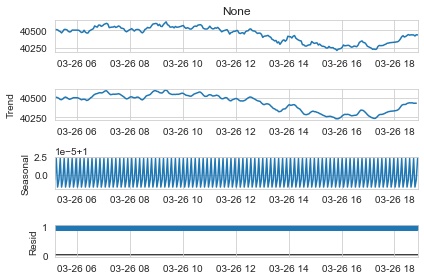

In [111]:
constant_3_minute_ts_trend_train_decom =  smt.tsa.seasonal.seasonal_decompose(constant_3_minute_ts_trend_train_temp,model='multiplicable', period = 3)
constant_3_minute_ts_trend_train_decom.plot()

Wir erkennen hier eine seasonale Struktur, wie wir sie schon vorher gesehen haben.
Wir werden daher wieder erst einfach differenzieren und danach zum lag 3 seasonal differenzieren. Danach werden wir den ACF- und PACF-Plot analysieren.

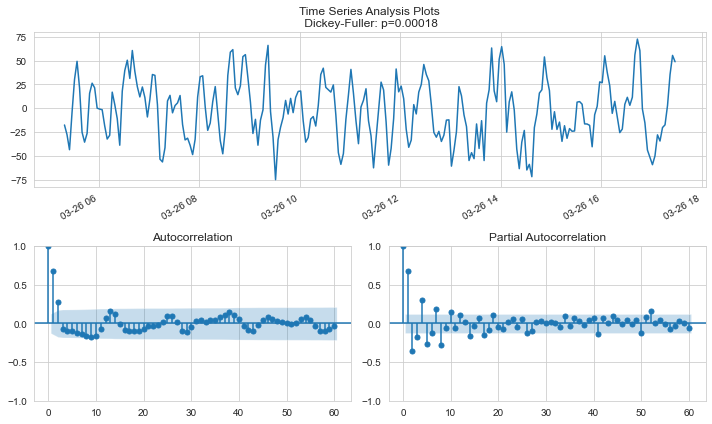

In [112]:
constant_3_minute_ts_trend_train_temp_diff_season = constant_3_minute_ts_trend_train_temp.diff(periods=3)
constant_3_minute_ts_trend_train_temp_diff_season = constant_3_minute_ts_trend_train_temp_diff_season[3:len(constant_3_minute_ts_trend_train_diff_season)]
plot_general_acf_pacf_and_dickey(constant_3_minute_ts_trend_train_temp_diff_season)

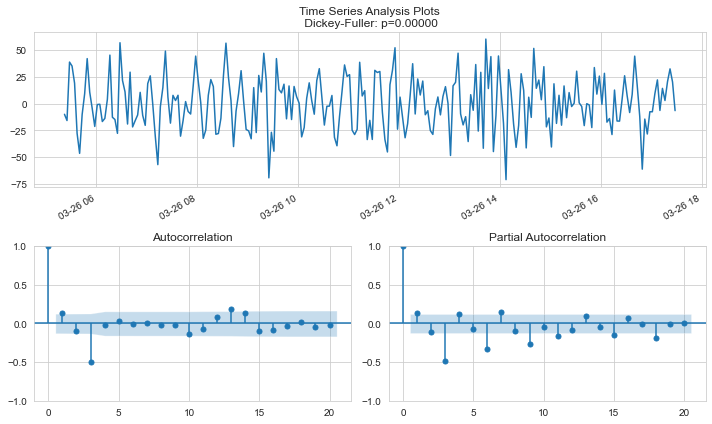

In [113]:
constant_3_minute_ts_trend_train_temp_diff_season_diff = constant_3_minute_ts_trend_train_temp_diff_season.diff()
constant_3_minute_ts_trend_train_temp_diff_season_diff = constant_3_minute_ts_trend_train_temp_diff_season_diff[1:len(constant_3_minute_ts_trend_train_diff_season)]
plot_general_acf_pacf_and_dickey(constant_3_minute_ts_trend_train_temp_diff_season_diff, lags=20)

Für die Ordnung der normalen Differenzierung wird hier so gewählt, dass p=2, d=1, und q=1 ist. Für die seasonale Ordnung wird P=2, D=1,Q=1 und die Periode 3 gewählt.

Wir werden jetzt das Modell mit diesen Parametern erstellen und uns danach die Summary ausgeben lassen.

In [114]:
constant_3_arma_temp = ARIMA(constant_3_minute_ts_trend_train_temp, order=(2,1,1), seasonal_order=(2,1,1,3), freq="3T")
constant_3_arma_temp_fit = constant_3_arma_temp.fit(start_params=[0,0,0,0,0,0,1])
constant_3_arma_temp_fit.summary()

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3T will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                            None   No. Observations:                  275
Model:             ARIMA(2, 1, 1)x(2, 1, 1, 3)   Log Likelihood               -1153.639
Date:                         Thu, 01 Sep 2022   AIC                           2321.278
Time:                                 19:44:22   BIC                           2346.493
Sample:                             03-26-2022   HQIC                          2331.402
                                  - 03-26-2022                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0481     12.454      0.004      0.997     -24.361      24.457
ar.L2         -0.0543      1.732     -0.031      0.975      -3.450       3.341
ma.L1          0.0910     12.455      0.007      0.994     -24.320      24.502
ar.S.L3       -0.0579      0.834     -0.069      0.945      -1.693       1.577
ar.S.L6       -0.0305      0.080     -0.380      0.704      -0.188       0.127
ma.S.L3       -0.9613      0.027    -34.988      0.000      -1.015      -0.907
sigma2       283.4221     22.746     12.460      0.000     238.841     328.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.38
Prob(Q):                              1.00   Prob(JB):                         0.18
Heteroskedasticity (H):               0.94   Skew:                            -0.08
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Wir werden jetzt dies Residuen des Modells auf ihre Verteilung hin testen.

In [115]:
get_tests_for_residuals(constant_3_arma_temp_fit.resid)

Ljung-Box-Test
Ljung-Box-Test Statistic: 45.267746234426106
Ljung-Box-Test P-Value: 1.0
Result: The residuals are   identical independent distributed
Shapiro-Wilk-Test
Shapiro-Wilk-Test Statistic: 0.06442147493362427
Shapiro-Wilk-Test P-Value: 1.615716870410864e-34
Result: The residuals are not normal independent distributed 


Die Residuen sind id verteilt, daher können wir mit diesem Modell weiterarbeiten. Wir werden jetzt Die Vorhersage für die nächsten 25 Zeitschritte berechnen und diese mit den Testdaten vergleichen.

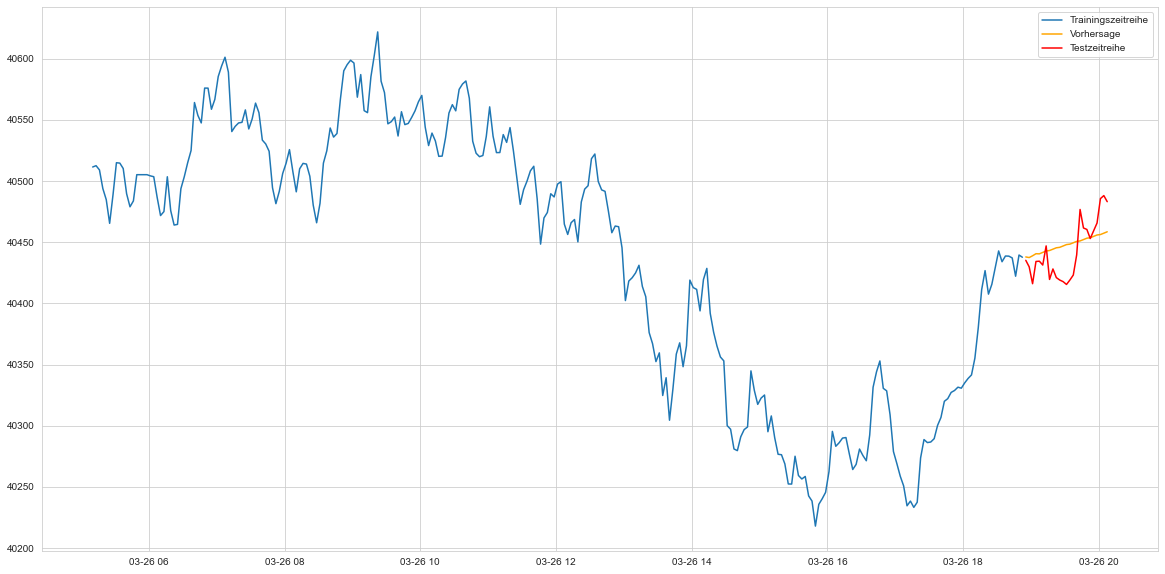

In [116]:
fig = plt.figure(figsize=(20,10))
constant_3_arma_temp_forecast = constant_3_arma_temp_fit.forecast(steps=25)
plt.plot(constant_3_minute_ts_trend_train_temp[0:len(constant_3_minute_ts_trend_train_temp)], label="Trainingszeitreihe")
plt.plot(constant_3_arma_temp_forecast, color = "orange", label="Vorhersage")
plt.plot(constant_3_minute_ts_trend_test_temp, color="red",label="Testzeitreihe")
plt.legend(loc="upper right")
plt.show()

Wir werden jetzt nochmal die Grafik mitsamt des gleitenden Mittels und der Konfidenzintervallen plotten.

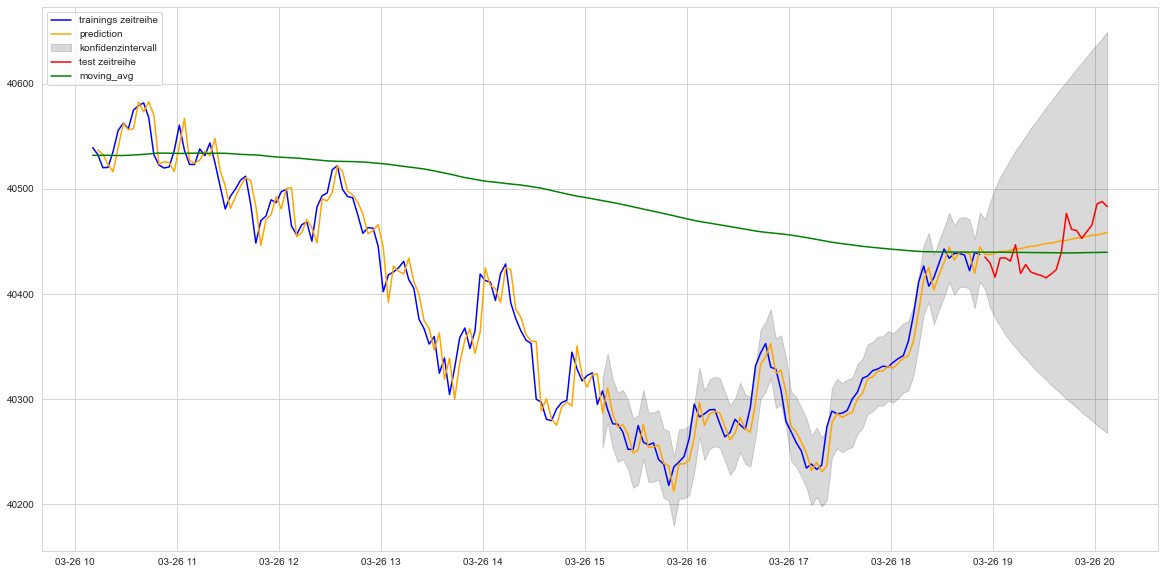

In [117]:
prediction_with_confidence(constant_3_arma_temp_fit,train_ts=constant_3_minute_ts_trend_train_temp, data_ts=constant_3_minute_ts_trend,start=constant_3_minute_ts_trend_train_temp.index[1], end=constant_3_minute_ts_trend.index[len(constant_3_minute_ts_trend)-1], start_plot=100, dynamic=False)


Wir sehen hier eine deutlich bessere Vorhersage im Vergleich zu den vorherigen. Damit ist gezeigt das Vorhersagen durch ein seasonale Modell eine gutes Ergebnis bringen können. Dennoch sei Angemerkt das Trendwenden mit diesen Daten und Modellen nicht gut vorhergesagt werden konnten.

### 4 Minuten <div id='vier-minuten'/>
wir werden uns nun kurz die Zeitreihen mit 4 und 5 Minuten anschauen und feststellen das diese keine seasonale Struktur erkennen lassen aber den ungefähr gleichen Zeitraum abdecken wie die Zeitreihe mit 3 Minuten Abstand. Daher werden wir keine weitere Analyse mit diesen Zeitreihen machen, da die 3 Minuten Zeitreihe eine ähnlichen Zeitraum abedeckt und es nur Sinn machen würden wenn wir durch die anderen Zeitreihen eine saisonale Strukur bekommen würden, diese noch einmal genauer zu untersuchen. 

In [ ]:
constant_4_minute_ts = constant_index_ts(ret[3], constant_second_step=0, constant_minute_step=4)

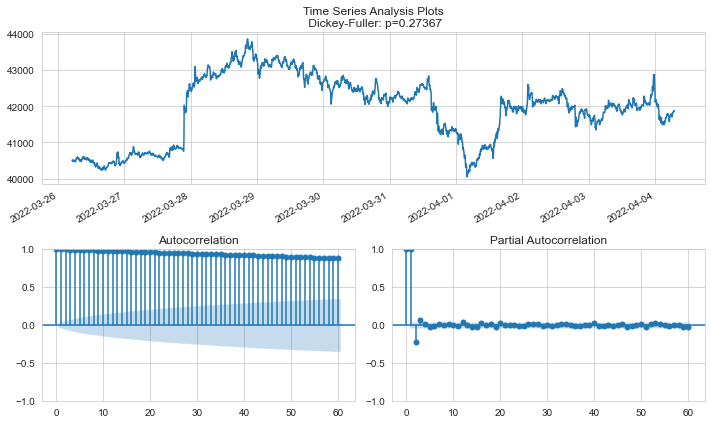

In [119]:
plot_general_acf_pacf_and_dickey(constant_4_minute_ts)

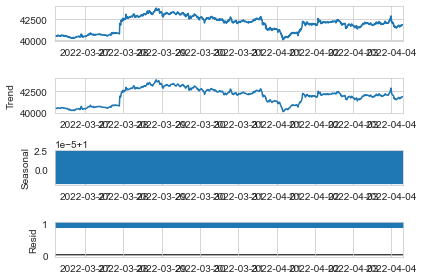

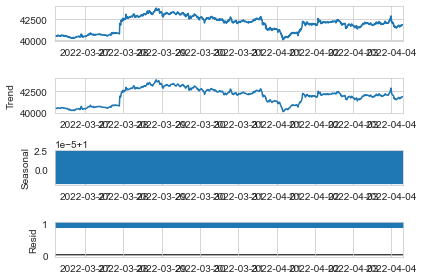

In [120]:
constant_4_minute_ts_decom = sm.tsa.seasonal_decompose(constant_4_minute_ts,model="multiplicable",period=4)
constant_4_minute_ts_decom.plot()

### 5 Minuten <div id='fünf-minuten'/>

In [ ]:
constant_5_minute_ts = constant_index_ts(ret[4], constant_second_step=0, constant_minute_step=5)

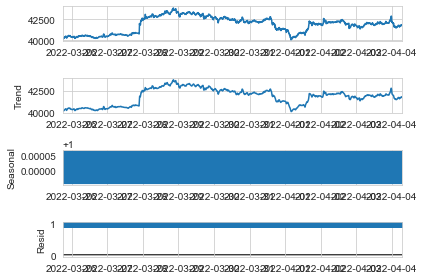

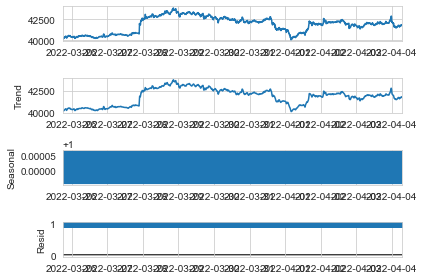

In [122]:
constant_5_minute_ts_decom = sm.tsa.seasonal_decompose(constant_5_minute_ts,model="multiplicable",period=4)
constant_5_minute_ts_decom.plot()

## Abschluss <div id='abschluss'/>

Wir haben gesehen das es sich lohnen kann einige Verarbeitungsschritte für die Daten zu unternehmen und diese in eine Zeitreihe mit konstantem Abstand zu bringen. Danach haben wir für die verschiedenen Zeitreihen eine Arima-Analyse gemacht. Bei einer Zeitreihe konnten wir sogar eine seasonale Struktur erkennen. Dieses Modell konnte grundsätzlich Trends sehr gut vorhersagen, aber war dafür bei Trendwenden sehr anfällig eine schlechte Vorhersage zu machen. Grundsätzlich war die Vorhersage aller Modelle deutlich schlechter so weit die Zeitschritte der Vorhersage gingen. Das deckt sich mit unserer Intuition, da die Werte der dann immer weiter zurückliegenden Vergangenheit immer weniger Einfluss auf die späteren Werte haben.